<a href="https://colab.research.google.com/github/stanislavfort/dissect-git-re-basin/blob/master/git_rebasin_Stan_MLP_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Replicating the Git Re-Basin experiments by Stanislav Fort, starting from their codebase (MLP on MNIST)
 
I got excited about the Git Re-Basin paper (https://arxiv.org/abs/2209.04836) yesterday (Sep 14 2022) and since the claims seemed pretty strong I decided to replicate the key results. I started from the codebase the authors put on GitHub (https://github.com/samuela/git-re-basin), and took the relevant bits and pieces, put them into a Colab, and write a one-click-runnable replication.

**tldr: I wasn't able to replicate the key observation that the permutation applied to a network moves it to a linearly connected basin of another** 

I added a lot of analysis on top to make sure I knew what was going on. Some things that seem to be true that I wanted to verify: 

1) the permutation procedure preserves the network exactly as it was in terms of its input-ouput behavior, exactly as it should
2) the (network + permutation)'s weight vector gets non-randomly closer to the network towards which the permutation was developed, as it should

However, the key claim that after the permutation is applied the new network is now **within the same convex, linearly connected basin of the other network, I was not able to replicate**. This is unusual since I literally took bits of code from the author's codebase. If you find a problem with my replication, please let me know on Twitter (@stanislavfort) or via email.

Here's the money plot:
Explanation: I have two networks trained from init (model 1 and model 2), and the permutation from the paper applied to model 2 towards model 1. The model 2 + permutation should be in the same linearly connected basin as model 1, which would suggest a nice linear path of low loss between the aqua triangle and the red circle. However, as you can see, there is a bump! The yellow line isn't a nice connected bridge and  on top of that the loss on the weight space cut defined by the model 1, model 2 and model 2 + permutation shows clearly 3 different basins, not 2, as the key claim would suggest.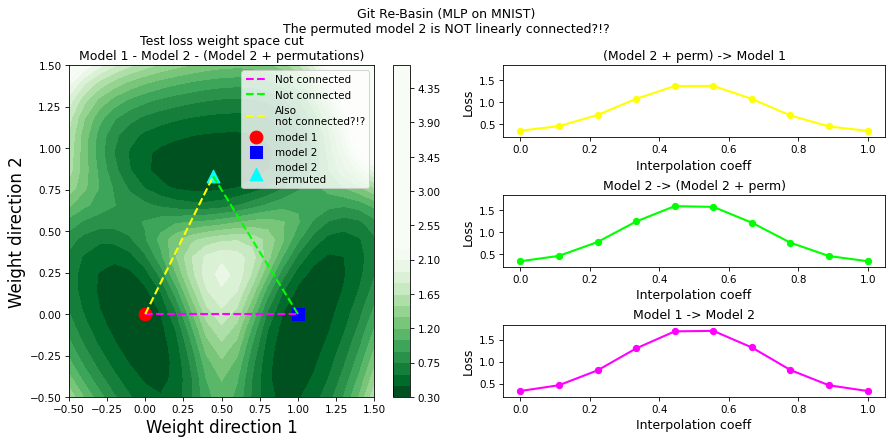

## Library imports

In [1]:
!pip install augmax
# Install the newest JAXlib version.
!pip install --upgrade -q pip jax jaxlib
# Install Flax at head:
!pip install --upgrade -q git+https://github.com/google/flax.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.0 MB 14.8 MB/s 
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 145.1/145.1 kB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.6/235.6 kB 25.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.1/51.1 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.3/85.3 kB 10.4 MB/s eta 0:00:00


## Permutation utils

In [2]:
from collections import defaultdict
from typing import NamedTuple

import jax.numpy as jnp
from jax import random
from scipy.optimize import linear_sum_assignment


class PermutationSpec(NamedTuple):
  perm_to_axes: dict
  axes_to_perm: dict

# def mlp_permutation_spec(num_hidden_layers: int) -> PermutationSpec:
#   """We assume that one permutation cannot appear in two axes of the same weight array."""
#   assert num_hidden_layers >= 1
#   return PermutationSpec(
#       perm_to_axes={
#           f"P_{i}": [(f"Dense_{i}/kernel", 1), (f"Dense_{i}/bias", 0), (f"Dense_{i+1}/kernel", 0)]
#           for i in range(num_hidden_layers)
#       },
#       axes_to_perm={
#           "Dense_0/kernel": (None, "P_0"),
#           **{f"Dense_{i}/kernel": (f"P_{i-1}", f"P_{i}")
#              for i in range(1, num_hidden_layers)},
#           **{f"Dense_{i}/bias": (f"P_{i}", )
#              for i in range(num_hidden_layers)},
#           f"Dense_{num_hidden_layers}/kernel": (f"P_{num_hidden_layers-1}", None),
#           f"Dense_{num_hidden_layers}/bias": (None, ),
#       })

def permutation_spec_from_axes_to_perm(axes_to_perm: dict) -> PermutationSpec:
  perm_to_axes = defaultdict(list)
  for wk, axis_perms in axes_to_perm.items():
    for axis, perm in enumerate(axis_perms):
      if perm is not None:
        perm_to_axes[perm].append((wk, axis))
  return PermutationSpec(perm_to_axes=dict(perm_to_axes), axes_to_perm=axes_to_perm)

def mlp_permutation_spec(num_hidden_layers: int) -> PermutationSpec:
  """We assume that one permutation cannot appear in two axes of the same weight array."""
  assert num_hidden_layers >= 1
  return permutation_spec_from_axes_to_perm({
      "Dense_0/kernel": (None, "P_0"),
      **{f"Dense_{i}/kernel": (f"P_{i-1}", f"P_{i}")
         for i in range(1, num_hidden_layers)},
      **{f"Dense_{i}/bias": (f"P_{i}", )
         for i in range(num_hidden_layers)},
      f"Dense_{num_hidden_layers}/kernel": (f"P_{num_hidden_layers-1}", None),
      f"Dense_{num_hidden_layers}/bias": (None, ),
  })

def vgg16_permutation_spec() -> PermutationSpec:
  return permutation_spec_from_axes_to_perm({
      "Conv_0/kernel": (None, None, None, "P_Conv_0"),
      **{f"Conv_{i}/kernel": (None, None, f"P_Conv_{i-1}", f"P_Conv_{i}")
         for i in range(1, 13)},
      **{f"Conv_{i}/bias": (f"P_Conv_{i}", )
         for i in range(13)},
      **{f"LayerNorm_{i}/scale": (f"P_Conv_{i}", )
         for i in range(13)},
      **{f"LayerNorm_{i}/bias": (f"P_Conv_{i}", )
         for i in range(13)},
      "Dense_0/kernel": ("P_Conv_12", "P_Dense_0"),
      "Dense_0/bias": ("P_Dense_0", ),
      "Dense_1/kernel": ("P_Dense_0", "P_Dense_1"),
      "Dense_1/bias": ("P_Dense_1", ),
      "Dense_2/kernel": ("P_Dense_1", None),
      "Dense_2/bias": (None, ),
  })

def resnet20_permutation_spec() -> PermutationSpec:
  conv = lambda name, p_in, p_out: {f"{name}/kernel": (None, None, p_in, p_out)}
  norm = lambda name, p: {f"{name}/scale": (p, ), f"{name}/bias": (p, )}
  dense = lambda name, p_in, p_out: {f"{name}/kernel": (p_in, p_out), f"{name}/bias": (p_out, )}

  # This is for easy blocks that use a residual connection, without any change in the number of channels.
  easyblock = lambda name, p: {
      **conv(f"{name}/conv1", p, f"P_{name}_inner"),
      **norm(f"{name}/norm1", f"P_{name}_inner"),
      **conv(f"{name}/conv2", f"P_{name}_inner", p),
      **norm(f"{name}/norm2", p)
  }

  # This is for blocks that use a residual connection, but change the number of channels via a Conv.
  shortcutblock = lambda name, p_in, p_out: {
      **conv(f"{name}/conv1", p_in, f"P_{name}_inner"),
      **norm(f"{name}/norm1", f"P_{name}_inner"),
      **conv(f"{name}/conv2", f"P_{name}_inner", p_out),
      **norm(f"{name}/norm2", p_out),
      **conv(f"{name}/shortcut/layers_0", p_in, p_out),
      **norm(f"{name}/shortcut/layers_1", p_out),
  }

  return permutation_spec_from_axes_to_perm({
      **conv("conv1", None, "P_bg0"),
      **norm("norm1", "P_bg0"),
      #
      **easyblock("blockgroups_0/blocks_0", "P_bg0"),
      **easyblock("blockgroups_0/blocks_1", "P_bg0"),
      **easyblock("blockgroups_0/blocks_2", "P_bg0"),
      #
      **shortcutblock("blockgroups_1/blocks_0", "P_bg0", "P_bg1"),
      **easyblock("blockgroups_1/blocks_1", "P_bg1"),
      **easyblock("blockgroups_1/blocks_2", "P_bg1"),
      #
      **shortcutblock("blockgroups_2/blocks_0", "P_bg1", "P_bg2"),
      **easyblock("blockgroups_2/blocks_1", "P_bg2"),
      **easyblock("blockgroups_2/blocks_2", "P_bg2"),
      #
      **dense("dense", "P_bg2", None),
  })

def get_permuted_param(ps: PermutationSpec, perm, k: str, params, except_axis=None):
  """Get parameter `k` from `params`, with the permutations applied."""
  w = params[k]
  for axis, p in enumerate(ps.axes_to_perm[k]):
    # Skip the axis we're trying to permute.
    if axis == except_axis:
      continue

    # None indicates that there is no permutation relevant to that axis.
    if p is not None:
      w = jnp.take(w, perm[p], axis=axis)

  return w

def apply_permutation(ps: PermutationSpec, perm, params):
  """Apply a `perm` to `params`."""
  return {k: get_permuted_param(ps, perm, k, params) for k in params.keys()}

def weight_matching(rng, ps: PermutationSpec, params_a, params_b, max_iter=100, init_perm=None):
  """Find a permutation of `params_b` to make them match `params_a`."""
  perm_sizes = {p: params_a[axes[0][0]].shape[axes[0][1]] for p, axes in ps.perm_to_axes.items()}

  perm = {p: jnp.arange(n) for p, n in perm_sizes.items()} if init_perm is None else init_perm
  perm_names = list(perm.keys())

  for iteration in range(max_iter):
    progress = False
    for p_ix in random.permutation(rngmix(rng, iteration), len(perm_names)):
      p = perm_names[p_ix]
      n = perm_sizes[p]
      A = jnp.zeros((n, n))
      for wk, axis in ps.perm_to_axes[p]:
        w_a = params_a[wk]
        w_b = get_permuted_param(ps, perm, wk, params_b, except_axis=axis)
        w_a = jnp.moveaxis(w_a, axis, 0).reshape((n, -1))
        w_b = jnp.moveaxis(w_b, axis, 0).reshape((n, -1))
        A += w_a @ w_b.T

      ri, ci = linear_sum_assignment(A, maximize=True)
      assert (ri == jnp.arange(len(ri))).all()

      oldL = jnp.vdot(A, jnp.eye(n)[perm[p]])
      newL = jnp.vdot(A, jnp.eye(n)[ci, :])
      print(f"{iteration}/{p}: {newL - oldL}")
      progress = progress or newL > oldL + 1e-12

      perm[p] = jnp.array(ci)

    if not progress:
      break

  return perm

def test_weight_matching():
  """If we just have a single hidden layer then it should converge after just one step."""
  ps = mlp_permutation_spec(num_hidden_layers=1)
  rng = random.PRNGKey(123)
  num_hidden = 10
  shapes = {
      "Dense_0/kernel": (2, num_hidden),
      "Dense_0/bias": (num_hidden, ),
      "Dense_1/kernel": (num_hidden, 3),
      "Dense_1/bias": (3, )
  }
  params_a = {k: random.normal(rngmix(rng, f"a-{k}"), shape) for k, shape in shapes.items()}
  params_b = {k: random.normal(rngmix(rng, f"b-{k}"), shape) for k, shape in shapes.items()}
  perm = weight_matching(rng, ps, params_a, params_b)
  print(perm)



## Utils

In [3]:
import operator
import re
import time

import jax.numpy as jnp
from flax import traverse_util
from flax.core import freeze, unfreeze
from jax import random, tree_map
from jax.tree_util import tree_reduce

rngmix = lambda rng, x: random.fold_in(rng, hash(x))

class RngPooper:
  """A stateful wrapper around stateless random.PRNGKey's."""

  def __init__(self, init_rng):
    self.rng = init_rng

  def poop(self):
    self.rng, rng_key = random.split(self.rng)
    return rng_key

def l1prox(x, alpha):
  return jnp.sign(x) * jnp.maximum(0, jnp.abs(x) - alpha)

def flatten_params(params):
  return {"/".join(k): v for k, v in traverse_util.flatten_dict(unfreeze(params)).items()}

def unflatten_params(flat_params):
  return freeze(
      traverse_util.unflatten_dict({tuple(k.split("/")): v
                                    for k, v in flat_params.items()}))

def merge_params(a, b):
  return unflatten_params({**a, **b})

def kmatch(pattern, key):
  regex = "^"
  i = 0
  while i < len(pattern):
    if pattern[i] == "*":
      if i + 1 < len(pattern) and pattern[i + 1] == "*":
        regex += "(.*)"
        i += 2
      else:
        regex += "([^\/]*)"
        i += 1
    else:
      regex += pattern[i]
      i += 1
  regex += "$"
  return re.fullmatch(regex, key)

assert kmatch("*", "a") is not None
assert kmatch("*", "a").group(0) == "a"
assert kmatch("*", "a").group(1) == "a"
assert kmatch("abc", "def") is None
assert kmatch("abc/*/ghi", "abc/def/ghi").group(1) == "def"
assert kmatch("abc/**/jkl", "abc/def/ghi/jkl").group(1) == "def/ghi"
assert kmatch("abc/*/jkl", "abc/def/ghi/jkl") is None
assert kmatch("**/*", "abc/def/ghi/jkl").group(1) == "abc/def/ghi"
assert kmatch("**/*", "abc/def/ghi/jkl").group(2) == "jkl"


## MLP model and dataset

In [4]:

"""Train an MLP on MNIST on one random seed. Serialize the model for
interpolation downstream."""
import argparse

import augmax
import flax
import jax
import jax.numpy as jnp
import numpy as np
import optax
import tensorflow as tf
import tensorflow_datasets as tfds

from flax import linen as nn
from flax.training.train_state import TrainState
from jax import jit, random, tree_map, value_and_grad, vmap
from tqdm import tqdm

# See https://github.com/tensorflow/tensorflow/issues/53831.

# See https://github.com/google/jax/issues/9454.
tf.config.set_visible_devices([], "GPU")

activation = nn.relu

class MLPModel(nn.Module):

  @nn.compact
  def __call__(self, x):
    x = jnp.reshape(x, (-1, 28 * 28))
    x = nn.Dense(512)(x)
    x = activation(x)
    x = nn.Dense(512)(x)
    x = activation(x)
    x = nn.Dense(512)(x)
    x = activation(x)
    x = nn.Dense(10)(x)
    x = nn.log_softmax(x)
    return x

def make_stuff(model):
  normalize_transform = augmax.ByteToFloat()

  @jit
  def batch_eval(params, images_u8, labels):
    images_f32 = vmap(normalize_transform)(None, images_u8)
    logits = model.apply({"params": params}, images_f32)
    y_onehot = jax.nn.one_hot(labels, 10)
    loss = jnp.mean(optax.softmax_cross_entropy(logits=logits, labels=y_onehot))
    num_correct = jnp.sum(jnp.argmax(logits, axis=-1) == jnp.argmax(y_onehot, axis=-1))
    return loss, {"num_correct": num_correct}

  # Stan's addition for saving predictions of the model to see how they differ
  @jit
  def batch_predictions(params, images_u8, labels):
    images_f32 = vmap(normalize_transform)(None, images_u8)
    logits = model.apply({"params": params}, images_f32)
    y_onehot = jax.nn.one_hot(labels, 10)
    loss = jnp.mean(optax.softmax_cross_entropy(logits=logits, labels=y_onehot))
    num_correct = jnp.sum(jnp.argmax(logits, axis=-1) == jnp.argmax(y_onehot, axis=-1))
    return loss, logits, y_onehot, {"num_correct": num_correct}

  @jit
  def step(train_state, images_f32, labels):
    (l, info), g = value_and_grad(batch_eval, has_aux=True)(train_state.params, images_f32, labels)
    return train_state.apply_gradients(grads=g), {"batch_loss": l, **info}

  def dataset_loss_and_accuracy(params, dataset, batch_size: int):
    num_examples = dataset["images_u8"].shape[0]
    assert num_examples % batch_size == 0
    num_batches = num_examples // batch_size
    batch_ix = jnp.arange(num_examples).reshape((num_batches, batch_size))
    # Can't use vmap or run in a single batch since that overloads GPU memory.
    losses, infos = zip(*[
        batch_eval(
            params,
            dataset["images_u8"][batch_ix[i, :], :, :, :],
            dataset["labels"][batch_ix[i, :]],
        ) for i in range(num_batches)
    ])
    return (
        jnp.sum(batch_size * jnp.array(losses)) / num_examples,
        sum(x["num_correct"] for x in infos) / num_examples,
    )

  # Stan's addition for saving predictions of the model to see how they differ
  def dataset_predictions(params, dataset, batch_size: int):
    num_examples = dataset["images_u8"].shape[0]
    assert num_examples % batch_size == 0
    num_batches = num_examples // batch_size
    batch_ix = jnp.arange(num_examples).reshape((num_batches, batch_size))
    # Can't use vmap or run in a single batch since that overloads GPU memory.
    losses, logits, y_onehots, infos = zip(*[
        batch_predictions(
            params,
            dataset["images_u8"][batch_ix[i, :], :, :, :],
            dataset["labels"][batch_ix[i, :]],
        ) for i in range(num_batches)
    ])
    return (
        jnp.sum(batch_size * jnp.array(losses)) / num_examples,
        sum(x["num_correct"] for x in infos) / num_examples,
        logits,
        y_onehots,
    )

  return {
      "normalize_transform": normalize_transform,
      "batch_eval": batch_eval,
      "step": step,
      "dataset_loss_and_accuracy": dataset_loss_and_accuracy,
      "dataset_predictions": dataset_predictions,
  }

def load_datasets():
  """Return the training and test datasets, unbatched."""
  # See https://www.tensorflow.org/datasets/overview#as_batched_tftensor_batch_size-1.
  train_ds_images_u8, train_ds_labels = tfds.as_numpy(
      tfds.load("mnist", split="train", batch_size=-1, as_supervised=True))
  test_ds_images_u8, test_ds_labels = tfds.as_numpy(
      tfds.load("mnist", split="test", batch_size=-1, as_supervised=True))
  train_ds = {"images_u8": train_ds_images_u8, "labels": train_ds_labels}
  test_ds = {"images_u8": test_ds_images_u8, "labels": test_ds_labels}
  return train_ds, test_ds



## Runs details

In [5]:
num_epochs = 20
batch_size = 500
seed = 12421
config_optimizer = "sgd" #"adam"
learning_rate = 1e-3

runs_to_collect = 2 #Stan's new stuff

rng = random.PRNGKey(seed)

In [6]:
# storing model params after training
flattened_models_list = []

for run_i in range(runs_to_collect):

  rng = random.PRNGKey(seed+run_i) # chaning the seed each run 
  rngmix = lambda rng, x: random.fold_in(rng, hash(x))

  model = MLPModel()
  stuff = make_stuff(model)

  print("--------------------------")
  print(f"Starting run {run_i}")


  train_ds, test_ds = load_datasets()
  print("train_ds labels hash", hash(np.array(train_ds["labels"]).tobytes()))
  print("test_ds labels hash", hash(np.array(test_ds["labels"]).tobytes()))

  num_train_examples = train_ds["images_u8"].shape[0]
  num_test_examples = test_ds["images_u8"].shape[0]
  assert num_train_examples % batch_size == 0
  print("num_train_examples", num_train_examples)
  print("num_test_examples", num_test_examples)

  if config_optimizer == "sgd":
    # See runs:
    # * https://wandb.ai/skainswo/playing-the-lottery/runs/3blb4uhm
    # * https://wandb.ai/skainswo/playing-the-lottery/runs/174j7umt
    # * https://wandb.ai/skainswo/playing-the-lottery/runs/td02y8gg
    lr_schedule = optax.warmup_cosine_decay_schedule(
        init_value=1e-6,
        peak_value=learning_rate,
        warmup_steps=10,
        # Confusingly, `decay_steps` is actually the total number of steps,
        # including the warmup.
        decay_steps=num_epochs * (num_train_examples // batch_size),
    )
    tx = optax.sgd(lr_schedule, momentum=0.9)
  elif config_optimizer == "adam":
    # See runs:
    # - https://wandb.ai/skainswo/playing-the-lottery/runs/1b1gztfx (trim-fire-575)
    # - https://wandb.ai/skainswo/playing-the-lottery/runs/1hrmw7wr (wild-dream-576)
    tx = optax.adam(learning_rate)
  else:
    # See runs:
    # - https://wandb.ai/skainswo/playing-the-lottery/runs/k4luj7er (faithful-spaceship-579)
    # - https://wandb.ai/skainswo/playing-the-lottery/runs/3ru7xy8c (sage-forest-580)
    tx = optax.adamw(learning_rate, weight_decay=1e-4)

  train_state = TrainState.create(
      apply_fn=model.apply,
      params=model.init(rngmix(rng, f"init{run_i}"), jnp.zeros((1, 28, 28, 1)))["params"],
      tx=tx,
  )

  for epoch in tqdm(range(num_epochs)):
    infos = []
  
    batch_ix = random.permutation(rngmix(rng, f"epoch-{epoch}"), num_train_examples).reshape(
        (-1, batch_size))
    for i in range(batch_ix.shape[0]):
      p = batch_ix[i, :]
      images_u8 = train_ds["images_u8"][p, :, :, :]
      labels = train_ds["labels"][p]
      train_state, info = stuff["step"](train_state, images_u8, labels)
    

    train_loss = sum(batch_size * x["batch_loss"] for x in infos) / num_train_examples
    train_accuracy = sum(x["num_correct"] for x in infos) / num_train_examples

    
    actest_loss, test_accuracy = stuff["dataset_loss_and_accuracy"](train_state.params, test_ds,
                                                                    10_000)

    params_l2 = tree_map(lambda x: jnp.sqrt(jnp.sum(x**2)),
                          flatten_params({"params_l2": train_state.params}))
    
    
  # summary
  print("-----------------")
  print(f"Run {run_i} DONE!")
  test_loss, test_accuracy = stuff["dataset_loss_and_accuracy"](train_state.params, test_ds,
                                                                10_000)
  train_loss, train_accuracy = stuff["dataset_loss_and_accuracy"](train_state.params, train_ds,
                                                                60_000)
  print(f"Run={run_i} test loss={test_loss} test accuracy={test_accuracy} train loss={train_loss} train accuracy={train_accuracy}")

  flattened_models_list.append(flatten_params(train_state.params))


--------------------------
Starting run 0


Dl Completed...:   0%|          | 0/4 [00:00<?, ? file/s]

Dataset mnist downloaded and prepared to ~/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.
train_ds labels hash 1633421567493271265
test_ds labels hash -755657542732042722
num_train_examples 60000
num_test_examples 10000


100%|██████████| 20/20 [00:10<00:00,  1.82it/s]


-----------------
Run 0 DONE!
Run=0 test loss=0.33368879556655884 test accuracy=0.905500054359436 train loss=0.3504005968570709 train accuracy=0.9014166593551636
--------------------------
Starting run 1
train_ds labels hash 1633421567493271265
test_ds labels hash -755657542732042722
num_train_examples 60000
num_test_examples 10000


100%|██████████| 20/20 [00:05<00:00,  3.49it/s]


-----------------
Run 1 DONE!
Run=1 test loss=0.3327438533306122 test accuracy=0.9066000580787659 train loss=0.3479721248149872 train accuracy=0.9022833704948425


In [7]:
# flattening params
assert len(flattened_models_list) >= 2
flattened_model1 = flattened_models_list[0]
flattened_model2 = flattened_models_list[1]

## Permuting the model

In [8]:
permutation_spec = mlp_permutation_spec(3)
final_permutation = weight_matching(random.PRNGKey(seed), permutation_spec,
                                    flattened_model1, flattened_model2)

0/P_0: 88.4608154296875
0/P_1: 43.10193634033203
0/P_2: 23.00216293334961
1/P_0: 9.411689758300781
1/P_2: 0.0
1/P_1: 0.8050079345703125
2/P_2: 2.91168212890625
2/P_0: 1.4564437866210938
2/P_1: 0.7252960205078125
3/P_0: 0.8473968505859375
3/P_1: 0.3138885498046875
3/P_2: 2.54754638671875
4/P_0: 0.5289993286132812
4/P_1: 0.0862274169921875
4/P_2: 0.4234771728515625
5/P_1: 0.0751190185546875
5/P_2: 0.40997314453125
5/P_0: 0.23331451416015625
6/P_1: 0.072296142578125
6/P_2: 0.47772979736328125
6/P_0: 0.16867828369140625
7/P_2: 0.0
7/P_1: 0.0354766845703125
7/P_0: 0.1947174072265625
8/P_1: 0.013946533203125
8/P_0: 0.0390167236328125
8/P_2: 0.542694091796875
9/P_0: 0.0
9/P_1: 0.003204345703125
9/P_2: 0.1214599609375
10/P_2: 0.0
10/P_0: 0.035491943359375
10/P_1: 0.0767364501953125
11/P_0: 0.1180877685546875
11/P_2: 0.20182037353515625
11/P_1: 0.0076141357421875
12/P_0: 0.09759521484375
12/P_1: 0.002197265625
12/P_2: 0.07088470458984375
13/P_2: 0.0
13/P_1: 0.0
13/P_0: 0.0886383056640625
14/P_0

In [9]:
# applying the permutation to the second model
flattened_model1_permuted = unflatten_params(
        apply_permutation(permutation_spec, final_permutation, flattened_model1)
        )
flattened_model2_permuted = unflatten_params(
        apply_permutation(permutation_spec, final_permutation, flattened_model2)
        )

## Performance verification

### Model 1

In [10]:
test_loss, test_accuracy = stuff["dataset_loss_and_accuracy"](unflatten_params(flattened_model1), test_ds,
                                                                  10_000)
train_loss, train_accuracy = stuff["dataset_loss_and_accuracy"](unflatten_params(flattened_model1), train_ds,
                                                                  60_000)
print("Model 1")
print(f"train_loss={train_loss} train_accuracy={train_accuracy}")
print(f"test_loss={test_loss} test_accuracy={test_accuracy}")

Model 1
train_loss=0.3504005968570709 train_accuracy=0.9014166593551636
test_loss=0.33368879556655884 test_accuracy=0.905500054359436


### Model 2

In [11]:
test_loss, test_accuracy = stuff["dataset_loss_and_accuracy"](unflatten_params(flattened_model2), test_ds,
                                                                  10_000)
train_loss, train_accuracy = stuff["dataset_loss_and_accuracy"](unflatten_params(flattened_model2), train_ds,
                                                                  60_000)
print("Model 2")
print(f"train_loss={train_loss} train_accuracy={train_accuracy}")
print(f"test_loss={test_loss} test_accuracy={test_accuracy}")

Model 2
train_loss=0.3479721248149872 train_accuracy=0.9022833704948425
test_loss=0.3327438533306122 test_accuracy=0.9066000580787659


### Model 1 with permutation

In [12]:
test_loss, test_accuracy = stuff["dataset_loss_and_accuracy"](unflatten_params(flattened_model1_permuted), test_ds,
                                                                  10_000)
train_loss, train_accuracy = stuff["dataset_loss_and_accuracy"](unflatten_params(flattened_model1_permuted), train_ds,
                                                                  60_000)
print("Model 1 with permutation")
print(f"train_loss={train_loss} train_accuracy={train_accuracy}")
print(f"test_loss={test_loss} test_accuracy={test_accuracy}")

Model 1 with permutation
train_loss=0.3504006266593933 train_accuracy=0.9014166593551636
test_loss=0.33368879556655884 test_accuracy=0.905500054359436


### Model 2 with permutation

In [13]:
test_loss, test_accuracy = stuff["dataset_loss_and_accuracy"](unflatten_params(flattened_model2_permuted), test_ds,
                                                                  10_000)
train_loss, train_accuracy = stuff["dataset_loss_and_accuracy"](unflatten_params(flattened_model2_permuted), train_ds,
                                                                  60_000)
print("Model 2 with permutation")
print(f"train_loss={train_loss} train_accuracy={train_accuracy}")
print(f"test_loss={test_loss} test_accuracy={test_accuracy}")

Model 2 with permutation
train_loss=0.3479721248149872 train_accuracy=0.9022833704948425
test_loss=0.3327438533306122 test_accuracy=0.9066000580787659


## Weight vector analysis

In [14]:
flattened_model1_permuted_flat = flatten_params(flattened_model1_permuted)
flattened_model2_permuted_flat = flatten_params(flattened_model2_permuted)

In [15]:
# all in long vectors
keys = flattened_model1.keys()

v1 = jnp.concatenate([flattened_model1[key].reshape([-1]) for key in keys],axis=0)
v2 = jnp.concatenate([flattened_model2[key].reshape([-1]) for key in keys],axis=0)
v1_perm = jnp.concatenate([flattened_model1_permuted_flat[key].reshape([-1]) for key in keys],axis=0)
v2_perm = jnp.concatenate([flattened_model2_permuted_flat[key].reshape([-1]) for key in keys],axis=0)

In [16]:
vectors_to_show = [
    ("model 1", v1),
    ("model 2", v2),
    ("model 1 + perms", v1_perm),
    ("model 2 + perms", v2_perm), 
]

for vector_str, vector in vectors_to_show:
  print(f"{vector_str} length**2={(jnp.sum(vector**2))}")

# the permutation should preserve the length

model 1 length**2=1571.5908203125
model 2 length**2=1576.0863037109375
model 1 + perms length**2=1571.5908203125
model 2 + perms length**2=1576.0863037109375


In [17]:
coses_grid = np.zeros((len(vectors_to_show),len(vectors_to_show)))
for i,(vector_str1, vector1) in enumerate(vectors_to_show):
  for j,(vector_str2, vector2) in enumerate(vectors_to_show):
    cos_now = jnp.sum(vector1*vector2)/jnp.sqrt(jnp.sum(vector1**2))/jnp.sqrt(jnp.sum(vector2**2))
    print(f"cos({vector_str1},{vector_str2})={cos_now}")
    coses_grid[i,j] = cos_now

cos(model 1,model 1)=1.0
cos(model 1,model 2)=-0.00010640504478942603
cos(model 1,model 1 + perms)=0.006295676808804274
cos(model 1,model 2 + perms)=0.11280826479196548
cos(model 2,model 1)=-0.00010640505206538364
cos(model 2,model 2)=1.0000001192092896
cos(model 2,model 1 + perms)=0.002893950557336211
cos(model 2,model 2 + perms)=0.0044810231775045395
cos(model 1 + perms,model 1)=0.006295676808804274
cos(model 1 + perms,model 2)=0.002893950557336211
cos(model 1 + perms,model 1 + perms)=1.0
cos(model 1 + perms,model 2 + perms)=-0.0001064046737155877
cos(model 2 + perms,model 1)=0.11280825734138489
cos(model 2 + perms,model 2)=0.0044810231775045395
cos(model 2 + perms,model 1 + perms)=-0.0001064046737155877
cos(model 2 + perms,model 2 + perms)=1.0000001192092896


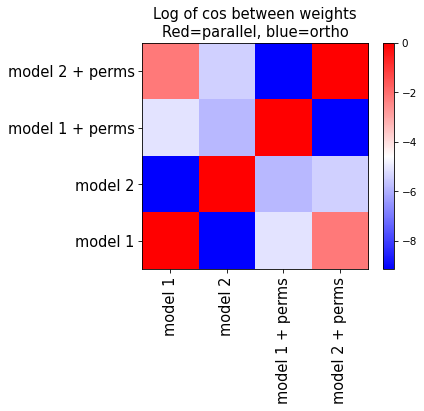

In [18]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize = (5,4),dpi=75)
plt.title("Log of cos between weights\nRed=parallel, blue=ortho",fontsize=14)
fig.patch.set_facecolor('white')
plt.imshow(np.log(np.abs(coses_grid)),cmap=plt.cm.bwr,origin="lower")
plt.xticks(range(len(vectors_to_show)), [x[0] for x in vectors_to_show],rotation = 90,fontsize=14)
plt.yticks(range(len(vectors_to_show)), [x[0] for x in vectors_to_show],fontsize=14)
plt.colorbar()
plt.show()


## Linear interpolations of weights = test for linear mode connectivity

In [19]:
def get_linear_combination(factor1,vector1,factor2,vector2):
  return dict(
      [(key,factor1*vector1[key]+factor2*vector2[key]) for key in vector1.keys()]
  )

### Model 1 -> Model 2

0 0.0 0.3336888
1 0.1111111111111111 0.4659357
2 0.2222222222222222 0.8148016
3 0.3333333333333333 1.3258684
4 0.4444444444444444 1.6946522
5 0.5555555555555556 1.6733446
6 0.6666666666666666 1.2906737
7 0.7777777777777777 0.7944396
8 0.8888888888888888 0.4600758
9 1.0 0.33274385


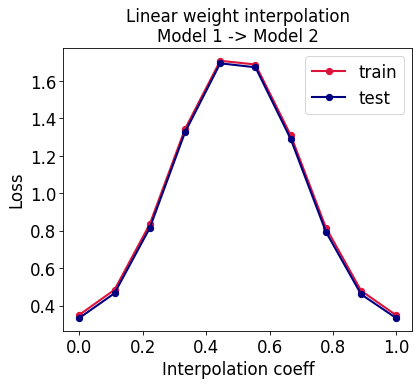

In [20]:
ts = np.linspace(0.0,1.0,10)

start_vector = flattened_model1
stop_vector = flattened_model2
name = "Model 1 -> Model 2"

test_losses_list = []
test_accs_list = []
train_losses_list = []
train_accs_list = []

for i,t in enumerate(ts):
  new_params = get_linear_combination(
      (1.0-t), start_vector, t, stop_vector
  )
  test_loss, test_accuracy = stuff["dataset_loss_and_accuracy"](unflatten_params(new_params), test_ds,
                                                                  10_000)
  test_losses_list.append(test_loss)
  test_accs_list.append(test_accuracy)

  train_loss, train_accuracy = stuff["dataset_loss_and_accuracy"](unflatten_params(new_params), train_ds,
                                                                  60_000)
  train_losses_list.append(train_loss)
  train_accs_list.append(train_accuracy)

  print(i,t,test_loss)

plt.figure(figsize=(6,5),dpi=75)
plt.gca().patch.set_facecolor('white')
plt.title(f"Linear weight interpolation\n{name}",fontsize=16)
plt.plot(ts,train_losses_list,label="train",marker="o",color="crimson",linewidth=2)
plt.plot(ts,test_losses_list,label="test",marker="o",color="navy",linewidth=2)
plt.xlabel("Interpolation coeff",fontsize=16)
plt.ylabel("Loss",fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=16)
plt.show()

### Model 1 -> Model 1 + permutations

0 0.0 0.3336888
1 0.1111111111111111 0.4281391
2 0.2222222222222222 0.6575428
3 0.3333333333333333 1.0039852
4 0.4444444444444444 1.2897536
5 0.5555555555555556 1.2888277
6 0.6666666666666666 0.9994192
7 0.7777777777777777 0.6537187
8 0.8888888888888888 0.42723155
9 1.0 0.33274385


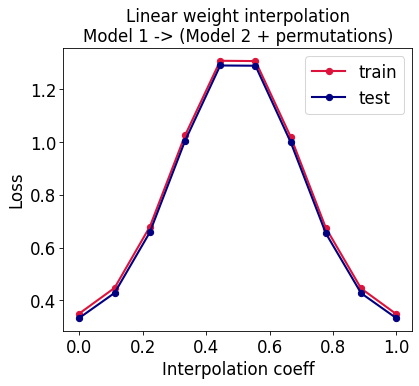

In [21]:
ts = np.linspace(0.0,1.0,10)

start_vector = flattened_model1
stop_vector = flattened_model2_permuted_flat
name = "Model 1 -> (Model 2 + permutations)"

test_losses_list = []
test_accs_list = []
train_losses_list = []
train_accs_list = []

for i,t in enumerate(ts):
  new_params = get_linear_combination(
      (1.0-t), start_vector, t, stop_vector
  )
  test_loss, test_accuracy = stuff["dataset_loss_and_accuracy"](unflatten_params(new_params), test_ds,
                                                                  10_000)
  test_losses_list.append(test_loss)
  test_accs_list.append(test_accuracy)

  train_loss, train_accuracy = stuff["dataset_loss_and_accuracy"](unflatten_params(new_params), train_ds,
                                                                  60_000)
  train_losses_list.append(train_loss)
  train_accs_list.append(train_accuracy)

  print(i,t,test_loss)

fig = plt.figure(figsize=(6,5),dpi=75)
fig.patch.set_facecolor('white')
plt.title(f"Linear weight interpolation\n{name}",fontsize=16)
plt.plot(ts,train_losses_list,label="train",marker="o",color="crimson",linewidth=2)
plt.plot(ts,test_losses_list,label="test",marker="o",color="navy",linewidth=2)
plt.xlabel("Interpolation coeff",fontsize=16)
plt.ylabel("Loss",fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=16)
plt.show()

### Model 2 -> Model 2 + permutations

0 0.0 0.33274385
1 0.1111111111111111 0.46210402
2 0.2222222222222222 0.7930109
3 0.3333333333333333 1.2802448
4 0.4444444444444444 1.6542329
5 0.5555555555555556 1.6567454
6 0.6666666666666666 1.2869235
7 0.7777777777777777 0.7966242
8 0.8888888888888888 0.46074358
9 1.0 0.33274385


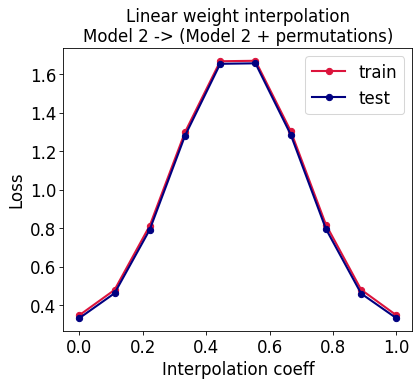

In [22]:
ts = np.linspace(0.0,1.0,10)

start_vector = flattened_model2
stop_vector = flattened_model2_permuted_flat
name = "Model 2 -> (Model 2 + permutations)"

test_losses_list = []
test_accs_list = []
train_losses_list = []
train_accs_list = []

for i,t in enumerate(ts):
  new_params = get_linear_combination(
      (1.0-t), start_vector, t, stop_vector
  )
  test_loss, test_accuracy = stuff["dataset_loss_and_accuracy"](unflatten_params(new_params), test_ds,
                                                                  10_000)
  test_losses_list.append(test_loss)
  test_accs_list.append(test_accuracy)

  train_loss, train_accuracy = stuff["dataset_loss_and_accuracy"](unflatten_params(new_params), train_ds,
                                                                  60_000)
  train_losses_list.append(train_loss)
  train_accs_list.append(train_accuracy)

  print(i,t,test_loss)

fig = plt.figure(figsize=(6,5),dpi=75)
fig.patch.set_facecolor('white')
plt.title(f"Linear weight interpolation\n{name}",fontsize=16)
plt.plot(ts,train_losses_list,label="train",marker="o",color="crimson",linewidth=2)
plt.plot(ts,test_losses_list,label="test",marker="o",color="navy",linewidth=2)
plt.xlabel("Interpolation coeff",fontsize=16)
plt.ylabel("Loss",fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=16)
plt.show()

### Model 2 -> Model 1 + permutations

0 0.0 0.33274385
1 0.1111111111111111 0.46485168
2 0.2222222222222222 0.8080559
3 0.3333333333333333 1.3084896
4 0.4444444444444444 1.6868069
5 0.5555555555555556 1.6908237
6 0.6666666666666666 1.3041146
7 0.7777777777777777 0.79673755
8 0.8888888888888888 0.46011817
9 1.0 0.3336888


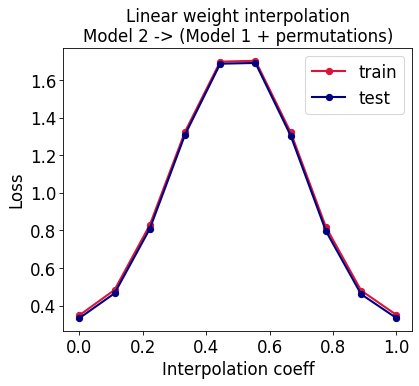

In [23]:
ts = np.linspace(0.0,1.0,10)

start_vector = flattened_model2
stop_vector = flattened_model1_permuted_flat
name = "Model 2 -> (Model 1 + permutations)"

test_losses_list = []
test_accs_list = []
train_losses_list = []
train_accs_list = []

for i,t in enumerate(ts):
  new_params = get_linear_combination(
      (1.0-t), start_vector, t, stop_vector
  )
  test_loss, test_accuracy = stuff["dataset_loss_and_accuracy"](unflatten_params(new_params), test_ds,
                                                                  10_000)
  test_losses_list.append(test_loss)
  test_accs_list.append(test_accuracy)

  train_loss, train_accuracy = stuff["dataset_loss_and_accuracy"](unflatten_params(new_params), train_ds,
                                                                  60_000)
  train_losses_list.append(train_loss)
  train_accs_list.append(train_accuracy)

  print(i,t,test_loss)

fig = plt.figure(figsize=(6,5),dpi=75)
fig.patch.set_facecolor('white')
plt.title(f"Linear weight interpolation\n{name}",fontsize=16)
plt.plot(ts,train_losses_list,label="train",marker="o",color="crimson",linewidth=2)
plt.plot(ts,test_losses_list,label="test",marker="o",color="navy",linewidth=2)
plt.xlabel("Interpolation coeff",fontsize=16)
plt.ylabel("Loss",fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=16)
plt.show()

### Model 1 -> Model 1 + permutations

0 0.0 0.3336888
1 0.1111111111111111 0.45462272
2 0.2222222222222222 0.7629065
3 0.3333333333333333 1.2219255
4 0.4444444444444444 1.585128
5 0.5555555555555556 1.598472
6 0.6666666666666666 1.2485178
7 0.7777777777777777 0.77879184
8 0.8888888888888888 0.4587199
9 1.0 0.3336888


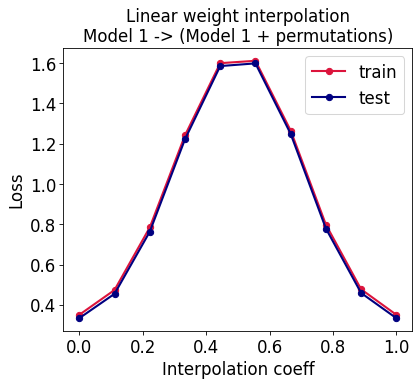

In [24]:
ts = np.linspace(0.0,1.0,10)

start_vector = flattened_model1
stop_vector = flattened_model1_permuted_flat
name = "Model 1 -> (Model 1 + permutations)"

test_losses_list = []
test_accs_list = []
train_losses_list = []
train_accs_list = []

for i,t in enumerate(ts):
  new_params = get_linear_combination(
      (1.0-t), start_vector, t, stop_vector
  )
  test_loss, test_accuracy = stuff["dataset_loss_and_accuracy"](unflatten_params(new_params), test_ds,
                                                                  10_000)
  test_losses_list.append(test_loss)
  test_accs_list.append(test_accuracy)

  train_loss, train_accuracy = stuff["dataset_loss_and_accuracy"](unflatten_params(new_params), train_ds,
                                                                  60_000)
  train_losses_list.append(train_loss)
  train_accs_list.append(train_accuracy)

  print(i,t,test_loss)

fig = plt.figure(figsize=(6,5),dpi=75)
fig.patch.set_facecolor('white')
plt.title(f"Linear weight interpolation\n{name}",fontsize=16)
plt.plot(ts,train_losses_list,label="train",marker="o",color="crimson",linewidth=2)
plt.plot(ts,test_losses_list,label="test",marker="o",color="navy",linewidth=2)
plt.xlabel("Interpolation coeff",fontsize=16)
plt.ylabel("Loss",fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=16)
plt.show()

## Predictions

In [25]:
def compare_predictions(
    model1,
    model2,
):

  _, _, logits1, _ = stuff["dataset_predictions"](model1, test_ds,
                                                                    10_000)
  _, _, logits2, _ = stuff["dataset_predictions"](model2, test_ds,
                                                                    10_000)
  
  return jnp.sum(jnp.argmax(logits1[0],axis=-1) != jnp.argmax(logits2[0],axis=-1))
  


In [26]:
models_to_show = [
    ("model 1", flattened_model1),
    ("model 2", flattened_model2),
    ("model 1 + perms", flattened_model1_permuted_flat),
    ("model 2 + perms", flattened_model2_permuted_flat), 
]

disagreement_grid = np.zeros((len(models_to_show),len(models_to_show)))
for i,(vector_str1, vector1) in enumerate(models_to_show):
  for j,(vector_str2, vector2) in enumerate(models_to_show):
    disagreement_now = compare_predictions(
        unflatten_params(vector1),
        unflatten_params(vector2)
        )
    print(f"Disagreemnt {vector_str1} vs {vector_str2}={disagreement_now}")
    disagreement_grid[i,j] = disagreement_now

Disagreemnt model 1 vs model 1=0
Disagreemnt model 1 vs model 2=339
Disagreemnt model 1 vs model 1 + perms=0
Disagreemnt model 1 vs model 2 + perms=339
Disagreemnt model 2 vs model 1=339
Disagreemnt model 2 vs model 2=0
Disagreemnt model 2 vs model 1 + perms=339
Disagreemnt model 2 vs model 2 + perms=0
Disagreemnt model 1 + perms vs model 1=0
Disagreemnt model 1 + perms vs model 2=339
Disagreemnt model 1 + perms vs model 1 + perms=0
Disagreemnt model 1 + perms vs model 2 + perms=339
Disagreemnt model 2 + perms vs model 1=339
Disagreemnt model 2 + perms vs model 2=0
Disagreemnt model 2 + perms vs model 1 + perms=339
Disagreemnt model 2 + perms vs model 2 + perms=0


## Loss landscape cuts

In [27]:
# reconstructing parameter dictionaries from flat vectors
def reconstruct(vector, example_flat_model, keys):
  i = 0
  output = dict()
  for key in keys:
    shape_now = example_flat_model[key].shape
    size_now = np.prod(shape_now)
    data_now = vector[i:i+size_now].reshape(shape_now)
    output[key] = data_now
    i = i + size_now
  return output



In [28]:
# testing it, should get all 0.0
rec = reconstruct(v1, flattened_model1, flattened_model1.keys())
for key in rec.keys():
  print(jnp.max(jnp.abs(flattened_model1[key] - rec[key])))
  assert jnp.max(jnp.abs(flattened_model1[key] - rec[key])) == 0.0

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


### Cut model1 - model2 - (model2+perm)

In [29]:
model1 = flattened_model1
model2 = flattened_model2
model3 = flattened_model2_permuted_flat
cut_str = "Model 1 - Model 2 - (Model 2 + permutations)"

keys = model1.keys()

v1 = jnp.concatenate([model1[key].reshape([-1]) for key in keys],axis=0)
v2 = jnp.concatenate([model2[key].reshape([-1]) for key in keys],axis=0)
v3 = jnp.concatenate([model3[key].reshape([-1]) for key in keys],axis=0)

basis1 = v2-v1
basis1_normed = basis1 / jnp.sqrt(jnp.sum(basis1**2.0))
basis2 = v3 - v1
basis2 = basis2 - jnp.sum(basis2*basis1_normed)*basis1_normed #orthogonalization
basis2_normed = basis2 / jnp.sqrt(jnp.sum(basis2**2.0))

scale = jnp.sqrt(jnp.sum(basis1**2))

t1s = np.linspace(-0.5,1.5,21)
t2s = np.linspace(-0.5,1.5,20)

acc_grid = np.zeros((len(t1s),len(t2s)))
loss_grid = np.zeros((len(t1s),len(t2s)))
logits_grid = np.zeros((len(t1s),len(t2s), 10000, 10))

for i1,t1 in enumerate(t1s):
  print(f"{i1}/{len(t1s)}")
  for i2,t2 in enumerate(t2s):

    new_flat_v = v1 + basis1_normed*t1*scale + basis2_normed*t2*scale
    reconstructed_flat = reconstruct(new_flat_v, model1, keys)
    actest_loss, test_accuracy, logits, onehots = stuff["dataset_predictions"](unflatten_params(reconstructed_flat), test_ds,
                                                                  10_000)
    logits_grid[i1,i2] = np.array(logits[0])
    
    acc_grid[i1,i2] = test_accuracy
    loss_grid[i1,i2] = actest_loss
  
def projection(vector):
  x = jnp.sum((vector - v1)*basis1_normed)/scale
  y = jnp.sum((vector - v1)*basis2_normed)/scale
  return x,y



0/21
1/21
2/21
3/21
4/21
5/21
6/21
7/21
8/21
9/21
10/21
11/21
12/21
13/21
14/21
15/21
16/21
17/21
18/21
19/21
20/21


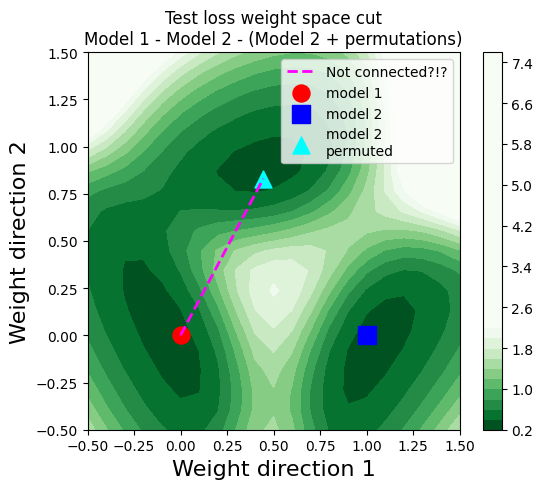

In [30]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize = (6,5),dpi=100)
fig.patch.set_facecolor('white')
plt.title(f"Test loss weight space cut\n{cut_str}")

plt.contourf(t1s,t2s,loss_grid.T,cmap=plt.cm.Greens_r,vmax=2.2,levels=40)
plt.colorbar()

x1,y1 = projection(v1)
plt.scatter([x1],[y1],marker="o",color="red",label="model 1",s=150)

x2,y2 = projection(v2)
plt.scatter([x2],[y2],marker="s",color="blue",label="model 2",s=150)

x2p,y2p = projection(v3)
plt.scatter([x2p],[y2p],marker="^",color="aqua",label="model 2\npermuted",s=150)


plt.plot([x1,x2p],[y1,y2p],linewidth=2,linestyle="--",color="fuchsia",label="Not connected?!?")

plt.xlabel("Weight direction 1",fontsize = 16)
plt.ylabel("Weight direction 2",fontsize = 16)


plt.legend(fontsize=10,ncol=1)

plt.show()

## Combined plot

In [31]:
def get_linear_cut(start_vector, stop_vector, steps=10):

  ts = np.linspace(0.0,1.0,steps)

  test_losses_list = []
  test_accs_list = []
  train_losses_list = []
  train_accs_list = []

  for i,t in enumerate(ts):
    new_params = get_linear_combination(
        (1.0-t), start_vector, t, stop_vector
    )
    test_loss, test_accuracy = stuff["dataset_loss_and_accuracy"](unflatten_params(new_params), test_ds,
                                                                    10_000)
    test_losses_list.append(test_loss)
    test_accs_list.append(test_accuracy)

    train_loss, train_accuracy = stuff["dataset_loss_and_accuracy"](unflatten_params(new_params), train_ds,
                                                                    60_000)
    train_losses_list.append(train_loss)
    train_accs_list.append(train_accuracy)

  return ts, test_losses_list, test_accs_list, train_losses_list, train_accs_list


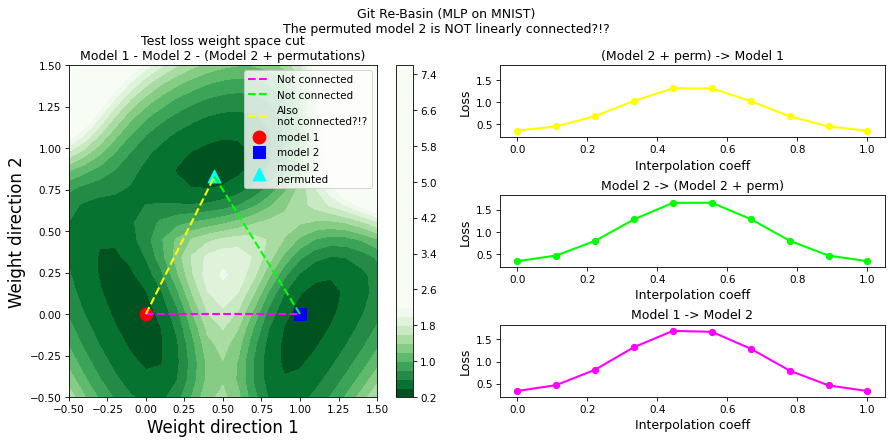

In [32]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12, 6), dpi = 75)
fig.patch.set_facecolor('white')

plt.suptitle("Git Re-Basin (MLP on MNIST)\nThe permuted model 2 is NOT linearly connected?!?")

plt.subplot(1,2,1)

plt.title(f"Test loss weight space cut\n{cut_str}")

plt.contourf(t1s,t2s,loss_grid.T,cmap=plt.cm.Greens_r,vmax=2.2,levels=40)
plt.colorbar()

x1,y1 = projection(v1)
plt.scatter([x1],[y1],marker="o",color="red",label="model 1",s=150)

x2,y2 = projection(v2)
plt.scatter([x2],[y2],marker="s",color="blue",label="model 2",s=150)

x2p,y2p = projection(v3)
plt.scatter([x2p],[y2p],marker="^",color="aqua",label="model 2\npermuted",s=150)


plt.plot([x1,x2],[y1,y2],linewidth=2,linestyle="--",color="fuchsia",label="Not connected")
plt.plot([x2,x2p],[y2,y2p],linewidth=2,linestyle="--",color="lime",label="Not connected")
plt.plot([x1,x2p],[y1,y2p],linewidth=2,linestyle="--",color="yellow",label="Also\nnot connected?!?")


plt.xlabel("Weight direction 1",fontsize = 16)
plt.ylabel("Weight direction 2",fontsize = 16)

plt.legend(fontsize=10,ncol=1)

# getting the data
all_test_losses = []
ts, test_losses_list, test_accs_list, train_losses_list, train_accs_list = get_linear_cut(flattened_model1, flattened_model2_permuted_flat, 10)
all_test_losses += test_losses_list
ts, test_losses_list, test_accs_list, train_losses_list, train_accs_list = get_linear_cut(flattened_model2, flattened_model2_permuted_flat, 10)
all_test_losses += test_losses_list
ts, test_losses_list, test_accs_list, train_losses_list, train_accs_list = get_linear_cut(flattened_model1, flattened_model2, 10)
all_test_losses += test_losses_list

lower_lim = np.min(test_losses_list)-(np.max(test_losses_list)-np.min(test_losses_list))*0.1
upper_lim = np.max(test_losses_list)+(np.max(test_losses_list)-np.min(test_losses_list))*0.1


plt.subplot(3,2,2)

ts, test_losses_list, test_accs_list, train_losses_list, train_accs_list = get_linear_cut(flattened_model1, flattened_model2_permuted_flat, 10)

plt.title(f"(Model 2 + perm) -> Model 1",fontsize=12)
plt.plot(ts,train_losses_list,label="train",marker="o",color="yellow",linewidth=2)
plt.xlabel("Interpolation coeff",fontsize=12)
plt.ylabel("Loss",fontsize=12)
plt.ylim([lower_lim, upper_lim])


plt.subplot(3,2,4)
ts, test_losses_list, test_accs_list, train_losses_list, train_accs_list = get_linear_cut(flattened_model2, flattened_model2_permuted_flat, 10)
plt.title(f"Model 2 -> (Model 2 + perm)",fontsize=12)
plt.plot(ts,test_losses_list,label="test",marker="o",color="lime",linewidth=2)
plt.xlabel("Interpolation coeff",fontsize=12)
plt.ylabel("Loss",fontsize=12)
plt.ylim([lower_lim, upper_lim])

plt.subplot(3,2,6)
ts, test_losses_list, test_accs_list, train_losses_list, train_accs_list = get_linear_cut(flattened_model1, flattened_model2, 10)
plt.title(f"Model 1 -> Model 2",fontsize=12)
plt.plot(ts,test_losses_list,label="test",marker="o",color="fuchsia",linewidth=2)
plt.ylim([np.min(test_losses_list),np.max(test_losses_list)])
plt.xlabel("Interpolation coeff",fontsize=12)
plt.ylabel("Loss",fontsize=12)

plt.ylim([lower_lim, upper_lim])

plt.tight_layout()
plt.subplots_adjust(top=0.85)
plt.show()

# Automating the full experiment to sweep over optimizers & LRs

## Wrappers

In [44]:
def get_optima(
  num_epochs = 20,
  batch_size = 500,
  seed = 12421,
  config_optimizer = "sgd", #"adam"
  learning_rate = 1e-3,
  runs_to_collect = 2,
):


  rng = random.PRNGKey(seed)


  # storing model params after training
  flattened_models_list = []

  for run_i in range(runs_to_collect):

    rng = random.PRNGKey(seed+run_i) # chaning the seed each run 
    rngmix = lambda rng, x: random.fold_in(rng, hash(x))

    model = MLPModel()
    stuff = make_stuff(model)

    print("--------------------------")
    print(f"Starting run {run_i}")


    train_ds, test_ds = load_datasets()
    print("train_ds labels hash", hash(np.array(train_ds["labels"]).tobytes()))
    print("test_ds labels hash", hash(np.array(test_ds["labels"]).tobytes()))

    num_train_examples = train_ds["images_u8"].shape[0]
    num_test_examples = test_ds["images_u8"].shape[0]
    assert num_train_examples % batch_size == 0
    print("num_train_examples", num_train_examples)
    print("num_test_examples", num_test_examples)

    if config_optimizer == "sgd":
      # See runs:
      # * https://wandb.ai/skainswo/playing-the-lottery/runs/3blb4uhm
      # * https://wandb.ai/skainswo/playing-the-lottery/runs/174j7umt
      # * https://wandb.ai/skainswo/playing-the-lottery/runs/td02y8gg
      lr_schedule = optax.warmup_cosine_decay_schedule(
          init_value=1e-6,
          peak_value=learning_rate,
          warmup_steps=10,
          # Confusingly, `decay_steps` is actually the total number of steps,
          # including the warmup.
          decay_steps=num_epochs * (num_train_examples // batch_size),
      )
      tx = optax.sgd(lr_schedule, momentum=0.9)
    elif config_optimizer == "adam":
      # See runs:
      # - https://wandb.ai/skainswo/playing-the-lottery/runs/1b1gztfx (trim-fire-575)
      # - https://wandb.ai/skainswo/playing-the-lottery/runs/1hrmw7wr (wild-dream-576)
      tx = optax.adam(learning_rate)
    else:
      # See runs:
      # - https://wandb.ai/skainswo/playing-the-lottery/runs/k4luj7er (faithful-spaceship-579)
      # - https://wandb.ai/skainswo/playing-the-lottery/runs/3ru7xy8c (sage-forest-580)
      tx = optax.adamw(learning_rate, weight_decay=1e-4)

    train_state = TrainState.create(
        apply_fn=model.apply,
        params=model.init(rngmix(rng, f"init{run_i}"), jnp.zeros((1, 28, 28, 1)))["params"],
        tx=tx,
    )

    for epoch in tqdm(range(num_epochs)):
      infos = []
    
      batch_ix = random.permutation(rngmix(rng, f"epoch-{epoch}"), num_train_examples).reshape(
          (-1, batch_size))
      for i in range(batch_ix.shape[0]):
        p = batch_ix[i, :]
        images_u8 = train_ds["images_u8"][p, :, :, :]
        labels = train_ds["labels"][p]
        train_state, info = stuff["step"](train_state, images_u8, labels)
      

      # train_loss = sum(batch_size * x["batch_loss"] for x in infos) / num_train_examples
      # train_accuracy = sum(x["num_correct"] for x in infos) / num_train_examples

      
      # actest_loss, test_accuracy = stuff["dataset_loss_and_accuracy"](train_state.params, test_ds,
      #                                                                 10_000)

      params_l2 = tree_map(lambda x: jnp.sqrt(jnp.sum(x**2)),
                            flatten_params({"params_l2": train_state.params}))
      
      
    # summary
    print("-----------------")
    print(f"Run {run_i} DONE!")
    test_loss, test_accuracy = stuff["dataset_loss_and_accuracy"](train_state.params, test_ds,
                                                                  10_000)
    train_loss, train_accuracy = stuff["dataset_loss_and_accuracy"](train_state.params, train_ds,
                                                                  60_000)
    print(f"Run={run_i} test loss={test_loss} test accuracy={test_accuracy} train loss={train_loss} train accuracy={train_accuracy}")

    flattened_models_list.append(flatten_params(train_state.params))

  return flattened_models_list


In [36]:
def analyze_optima(
  flattened_model1,
  flattened_model2    
):

  permutation_spec = mlp_permutation_spec(3)
  final_permutation = weight_matching(random.PRNGKey(seed), permutation_spec,
                                      flattened_model1, flattened_model2)

  # applying the permutation to the second model
  flattened_model1_permuted = unflatten_params(
          apply_permutation(permutation_spec, final_permutation, flattened_model1)
          )
  flattened_model2_permuted = unflatten_params(
          apply_permutation(permutation_spec, final_permutation, flattened_model2)
          )
  
  flattened_model1_permuted_flat = flatten_params(flattened_model1_permuted)
  flattened_model2_permuted_flat = flatten_params(flattened_model2_permuted)


  model1_test_loss, model1_test_accuracy = stuff["dataset_loss_and_accuracy"](unflatten_params(flattened_model1), test_ds,
                                                                    10_000)
  model1_train_loss, model1_train_accuracy = stuff["dataset_loss_and_accuracy"](unflatten_params(flattened_model1), train_ds,
                                                                    60_000)


  model2_test_loss, model2_test_accuracy = stuff["dataset_loss_and_accuracy"](unflatten_params(flattened_model2), test_ds,
                                                                    10_000)
  model2_train_loss, model2_train_accuracy = stuff["dataset_loss_and_accuracy"](unflatten_params(flattened_model2), train_ds,
                                                                    60_000)


  model2_permuted_test_loss, model2_permuted_test_accuracy = stuff["dataset_loss_and_accuracy"](unflatten_params(flattened_model2_permuted), test_ds,
                                                                    10_000)
  model2_permuted_train_loss, model2_permuted_train_accuracy = stuff["dataset_loss_and_accuracy"](unflatten_params(flattened_model2_permuted), train_ds,
                                                                    60_000)
  
  # get values in the middle
  ts, test_losses_list, test_accs_list, train_losses_list, train_accs_list = get_linear_cut(flattened_model1, flattened_model2, 3)
  bump_1_to_2 = test_losses_list[1]

  ts, test_losses_list, test_accs_list, train_losses_list, train_accs_list = get_linear_cut(flattened_model1, flattened_model2_permuted_flat, 3)
  bump_1_to_2perm = test_losses_list[1]

  ts, test_losses_list, test_accs_list, train_losses_list, train_accs_list = get_linear_cut(flattened_model2, flattened_model2_permuted_flat, 3)
  bump_2_to_2perm = test_losses_list[1]

  return {
    "model1_test_loss": model1_test_loss,
    "model2_test_loss": model2_test_loss,
    "model2_permuted_test_loss": model2_permuted_test_loss,
    "bump_1_to_2": bump_1_to_2,
    "bump_1_to_2perm": bump_1_to_2perm,
    "bump_2_to_2perm": bump_2_to_2perm,
  }


## SGD Experimental sweep

In [121]:
reps = 1
LRs = np.exp(np.linspace(np.log(1e-4),np.log(0.1),10))
optimizers = ["sgd"]
epochs = 50

In [122]:
all_flattened_models_tuples = [] # collecting all solutions every
stored_results_dict = []

for rep in range(reps): # to get error bars
  for i_opt, optimizer in enumerate(optimizers):
    for i_LR, LR in enumerate(LRs):

      print("*****************************************")
      print(f"Experiment {len(stored_results_dict)} / {reps*len(optimizers)*len(LRs)}")

      flattened_models_list = get_optima(
          num_epochs = epochs,
          config_optimizer = optimizer,
          learning_rate = LR,
          seed = int(np.random.rand()*100000000),
          )
      
      flattened_model1 = flattened_models_list[0]
      flattened_model2 = flattened_models_list[1]
      results_dict = analyze_optima(flattened_model1,flattened_model2)

      results_dict["LR"] = LR
      results_dict["optimizer"] = optimizer
      results_dict["epochs"] = epochs
      
      stored_results_dict.append(results_dict)
      all_flattened_models_tuples.append(flattened_models_list)

      print(results_dict)

*****************************************
Experiment 0 / 10
--------------------------
Starting run 0
train_ds labels hash 1633421567493271265
test_ds labels hash -755657542732042722
num_train_examples 60000
num_test_examples 10000


100%|██████████| 50/50 [00:12<00:00,  4.07it/s]


-----------------
Run 0 DONE!
Run=0 test loss=0.9369975328445435 test accuracy=0.8098000288009644 train loss=0.9593496322631836 train accuracy=0.7988499999046326
--------------------------
Starting run 1
train_ds labels hash 1633421567493271265
test_ds labels hash -755657542732042722
num_train_examples 60000
num_test_examples 10000


100%|██████████| 50/50 [00:12<00:00,  4.14it/s]


-----------------
Run 1 DONE!
Run=1 test loss=0.9893447756767273 test accuracy=0.8127000331878662 train loss=1.0137306451797485 train accuracy=0.8065000176429749
0/P_0: 87.9324722290039
0/P_1: 43.36274719238281
0/P_2: 24.330177307128906
1/P_0: 9.454071044921875
1/P_2: 0.0
1/P_1: 1.106414794921875
2/P_2: 3.2466888427734375
2/P_0: 1.061309814453125
2/P_1: 0.285400390625
3/P_0: 0.38336944580078125
3/P_1: 0.019256591796875
3/P_2: 0.9462356567382812
4/P_0: 0.21396636962890625
4/P_1: 0.0731353759765625
4/P_2: 0.274139404296875
5/P_1: 0.1006622314453125
5/P_2: 0.5828628540039062
5/P_0: 0.3113555908203125
6/P_1: 0.0548248291015625
6/P_2: 0.4084625244140625
6/P_0: 0.1375732421875
7/P_2: 0.0
7/P_1: 0.073883056640625
7/P_0: 0.14936065673828125
8/P_1: 0.0
8/P_0: 0.0
8/P_2: 0.5862884521484375
9/P_0: 0.0
9/P_1: 0.0
9/P_2: 0.0
{'model1_test_loss': DeviceArray(0.93699753, dtype=float32), 'model2_test_loss': DeviceArray(0.9893448, dtype=float32), 'model2_permuted_test_loss': DeviceArray(0.9893448, dtyp

100%|██████████| 50/50 [00:12<00:00,  4.13it/s]


-----------------
Run 0 DONE!
Run=0 test loss=0.4777356684207916 test accuracy=0.8767000436782837 train loss=0.49715110659599304 train accuracy=0.8701000213623047
--------------------------
Starting run 1
train_ds labels hash 1633421567493271265
test_ds labels hash -755657542732042722
num_train_examples 60000
num_test_examples 10000


100%|██████████| 50/50 [00:12<00:00,  4.06it/s]


-----------------
Run 1 DONE!
Run=1 test loss=0.4654730558395386 test accuracy=0.8819000124931335 train loss=0.480959951877594 train accuracy=0.8772667050361633
0/P_0: 86.19246673583984
0/P_1: 42.832862854003906
0/P_2: 23.20125961303711
1/P_0: 9.638961791992188
1/P_2: 0.0
1/P_1: 1.4367828369140625
2/P_2: 3.2559585571289062
2/P_0: 1.757171630859375
2/P_1: 0.54449462890625
3/P_0: 0.7360382080078125
3/P_1: 0.258758544921875
3/P_2: 2.5062713623046875
4/P_0: 0.38323974609375
4/P_1: 0.0810699462890625
4/P_2: 0.543548583984375
5/P_1: 0.0123443603515625
5/P_2: 0.1434783935546875
5/P_0: 0.2115936279296875
6/P_1: 0.0
6/P_2: 0.0
6/P_0: 0.0
{'model1_test_loss': DeviceArray(0.47773567, dtype=float32), 'model2_test_loss': DeviceArray(0.46547306, dtype=float32), 'model2_permuted_test_loss': DeviceArray(0.46547306, dtype=float32), 'bump_1_to_2': DeviceArray(1.8826095, dtype=float32), 'bump_1_to_2perm': DeviceArray(1.5764128, dtype=float32), 'bump_2_to_2perm': DeviceArray(1.8180059, dtype=float32), 'LR

100%|██████████| 50/50 [00:12<00:00,  4.09it/s]


-----------------
Run 0 DONE!
Run=0 test loss=0.3088226318359375 test accuracy=0.9125000238418579 train loss=0.32547423243522644 train accuracy=0.9087666869163513
--------------------------
Starting run 1
train_ds labels hash 1633421567493271265
test_ds labels hash -755657542732042722
num_train_examples 60000
num_test_examples 10000


100%|██████████| 50/50 [00:12<00:00,  4.10it/s]


-----------------
Run 1 DONE!
Run=1 test loss=0.3103661835193634 test accuracy=0.9123000502586365 train loss=0.32188689708709717 train accuracy=0.9080166816711426
0/P_0: 87.06217193603516
0/P_1: 42.810218811035156
0/P_2: 24.472923278808594
1/P_0: 10.342254638671875
1/P_2: 0.0
1/P_1: 0.8364105224609375
2/P_2: 2.4150772094726562
2/P_0: 1.1932525634765625
2/P_1: 0.42608642578125
3/P_0: 0.5568923950195312
3/P_1: 0.1379547119140625
3/P_2: 1.7927932739257812
4/P_0: 0.3669281005859375
4/P_1: 0.018157958984375
4/P_2: 0.40137481689453125
5/P_1: 0.0
5/P_2: 0.0
5/P_0: 0.0436859130859375
6/P_1: 0.009521484375
6/P_2: 0.1109619140625
6/P_0: 0.05603790283203125
7/P_2: 0.0
7/P_1: 0.0
7/P_0: 0.0
{'model1_test_loss': DeviceArray(0.30882263, dtype=float32), 'model2_test_loss': DeviceArray(0.31036618, dtype=float32), 'model2_permuted_test_loss': DeviceArray(0.31036612, dtype=float32), 'bump_1_to_2': DeviceArray(1.6588213, dtype=float32), 'bump_1_to_2perm': DeviceArray(1.2749197, dtype=float32), 'bump_2_to

100%|██████████| 50/50 [00:12<00:00,  4.09it/s]


-----------------
Run 0 DONE!
Run=0 test loss=0.2296987920999527 test accuracy=0.9349000453948975 train loss=0.23592190444469452 train accuracy=0.9325667023658752
--------------------------
Starting run 1
train_ds labels hash 1633421567493271265
test_ds labels hash -755657542732042722
num_train_examples 60000
num_test_examples 10000


100%|██████████| 50/50 [00:12<00:00,  4.09it/s]


-----------------
Run 1 DONE!
Run=1 test loss=0.23173701763153076 test accuracy=0.93340003490448 train loss=0.23717442154884338 train accuracy=0.9325000047683716
0/P_0: 85.64693450927734
0/P_1: 43.98310089111328
0/P_2: 24.623336791992188
1/P_0: 10.513015747070312
1/P_2: 0.0
1/P_1: 1.0250930786132812
2/P_2: 3.2592849731445312
2/P_0: 1.3718719482421875
2/P_1: 0.512847900390625
3/P_0: 0.7253265380859375
3/P_1: 0.1011505126953125
3/P_2: 1.7783737182617188
4/P_0: 0.5222625732421875
4/P_1: 0.1302947998046875
4/P_2: 0.6106491088867188
5/P_1: 0.0302581787109375
5/P_2: 0.36533355712890625
5/P_0: 0.3332672119140625
6/P_1: 0.1284942626953125
6/P_2: 0.47796630859375
6/P_0: 0.170074462890625
7/P_2: 0.0
7/P_1: 0.07293701171875
7/P_0: 0.1515960693359375
8/P_1: 0.0374755859375
8/P_0: 0.0405426025390625
8/P_2: 0.5541152954101562
9/P_0: 0.0
9/P_1: 0.0257720947265625
9/P_2: 0.21856689453125
10/P_2: 0.0
10/P_0: 0.0794677734375
10/P_1: 0.04052734375
11/P_0: 0.090728759765625
11/P_2: 0.25286102294921875
11/

100%|██████████| 50/50 [00:12<00:00,  4.03it/s]


-----------------
Run 0 DONE!
Run=0 test loss=0.15705446898937225 test accuracy=0.9547000527381897 train loss=0.15347789227962494 train accuracy=0.9570333361625671
--------------------------
Starting run 1
train_ds labels hash 1633421567493271265
test_ds labels hash -755657542732042722
num_train_examples 60000
num_test_examples 10000


100%|██████████| 50/50 [00:12<00:00,  3.96it/s]


-----------------
Run 1 DONE!
Run=1 test loss=0.15636713802814484 test accuracy=0.9532000422477722 train loss=0.15429574251174927 train accuracy=0.956000030040741
0/P_0: 87.8568115234375
0/P_1: 45.46442413330078
0/P_2: 27.787460327148438
1/P_0: 10.353874206542969
1/P_2: 0.0
1/P_1: 1.5656356811523438
2/P_2: 3.5596466064453125
2/P_0: 1.7790451049804688
2/P_1: 0.45611572265625
3/P_0: 0.7873916625976562
3/P_1: 0.1766815185546875
3/P_2: 1.7170181274414062
4/P_0: 0.24314117431640625
4/P_1: 0.190826416015625
4/P_2: 0.32622528076171875
5/P_1: 0.152740478515625
5/P_2: 0.26830291748046875
5/P_0: 0.6245498657226562
6/P_1: 0.0
6/P_2: 0.0
6/P_0: 0.0
{'model1_test_loss': DeviceArray(0.15705447, dtype=float32), 'model2_test_loss': DeviceArray(0.15636714, dtype=float32), 'model2_permuted_test_loss': DeviceArray(0.15636714, dtype=float32), 'bump_1_to_2': DeviceArray(1.6500607, dtype=float32), 'bump_1_to_2perm': DeviceArray(1.0891303, dtype=float32), 'bump_2_to_2perm': DeviceArray(1.5754898, dtype=float

100%|██████████| 50/50 [00:12<00:00,  4.06it/s]


-----------------
Run 0 DONE!
Run=0 test loss=0.10196800529956818 test accuracy=0.9701000452041626 train loss=0.08290199935436249 train accuracy=0.9768999814987183
--------------------------
Starting run 1
train_ds labels hash 1633421567493271265
test_ds labels hash -755657542732042722
num_train_examples 60000
num_test_examples 10000


100%|██████████| 50/50 [00:12<00:00,  4.01it/s]


-----------------
Run 1 DONE!
Run=1 test loss=0.10161235183477402 test accuracy=0.9699000716209412 train loss=0.08265171200037003 train accuracy=0.9770500063896179
0/P_0: 91.38517761230469
0/P_1: 42.559844970703125
0/P_2: 29.31598663330078
1/P_0: 11.005516052246094
1/P_2: 0.0
1/P_1: 1.3044815063476562
2/P_2: 3.9351272583007812
2/P_0: 1.9131622314453125
2/P_1: 0.5680694580078125
3/P_0: 1.2534866333007812
3/P_1: 0.1147613525390625
3/P_2: 2.5751113891601562
4/P_0: 0.16982269287109375
4/P_1: 0.5189971923828125
4/P_2: 0.8140716552734375
5/P_1: 0.1101226806640625
5/P_2: 0.1074371337890625
5/P_0: 0.2189178466796875
6/P_1: 0.0
6/P_2: 0.0
6/P_0: 0.0
{'model1_test_loss': DeviceArray(0.10196801, dtype=float32), 'model2_test_loss': DeviceArray(0.10161235, dtype=float32), 'model2_permuted_test_loss': DeviceArray(0.10161236, dtype=float32), 'bump_1_to_2': DeviceArray(1.704778, dtype=float32), 'bump_1_to_2perm': DeviceArray(0.9741342, dtype=float32), 'bump_2_to_2perm': DeviceArray(1.4645425, dtype=fl

100%|██████████| 50/50 [00:12<00:00,  4.03it/s]


-----------------
Run 0 DONE!
Run=0 test loss=0.06982932239770889 test accuracy=0.9773000478744507 train loss=0.02723604068160057 train accuracy=0.9940333366394043
--------------------------
Starting run 1
train_ds labels hash 1633421567493271265
test_ds labels hash -755657542732042722
num_train_examples 60000
num_test_examples 10000


100%|██████████| 50/50 [00:12<00:00,  4.05it/s]


-----------------
Run 1 DONE!
Run=1 test loss=0.07259545475244522 test accuracy=0.9772000312805176 train loss=0.027883324772119522 train accuracy=0.9940500259399414
0/P_0: 91.33686828613281
0/P_1: 47.67793273925781
0/P_2: 35.42088317871094
1/P_0: 9.90325927734375
1/P_2: 0.0
1/P_1: 3.0834808349609375
2/P_2: 4.312934875488281
2/P_0: 2.2984237670898438
2/P_1: 1.2292938232421875
3/P_0: 0.996337890625
3/P_1: 0.2228546142578125
3/P_2: 2.85345458984375
4/P_0: 0.3845367431640625
4/P_1: 0.2854156494140625
4/P_2: 0.5803375244140625
5/P_1: 0.0452423095703125
5/P_2: 0.3499603271484375
5/P_0: 0.5256729125976562
6/P_1: 0.0102081298828125
6/P_2: 0.058563232421875
6/P_0: 0.0540771484375
7/P_2: 0.0
7/P_1: 0.0504608154296875
7/P_0: 0.15532684326171875
8/P_1: 0.0941162109375
8/P_0: 0.05609130859375
8/P_2: 0.60101318359375
9/P_0: 0.0
9/P_1: 0.0
9/P_2: 0.0
{'model1_test_loss': DeviceArray(0.06982932, dtype=float32), 'model2_test_loss': DeviceArray(0.07259545, dtype=float32), 'model2_permuted_test_loss': De

100%|██████████| 50/50 [00:12<00:00,  4.09it/s]


-----------------
Run 0 DONE!
Run=0 test loss=0.065835140645504 test accuracy=0.9797000288963318 train loss=0.004712184891104698 train accuracy=0.9997833371162415
--------------------------
Starting run 1
train_ds labels hash 1633421567493271265
test_ds labels hash -755657542732042722
num_train_examples 60000
num_test_examples 10000


100%|██████████| 50/50 [00:12<00:00,  4.01it/s]


-----------------
Run 1 DONE!
Run=1 test loss=0.07050897926092148 test accuracy=0.9800000190734863 train loss=0.004859945736825466 train accuracy=0.999750018119812
0/P_0: 99.5239028930664
0/P_1: 51.72739028930664
0/P_2: 40.31602478027344
1/P_0: 10.6776123046875
1/P_2: 0.0
1/P_1: 5.99505615234375
2/P_2: 6.1670074462890625
2/P_0: 3.8276214599609375
2/P_1: 1.4300384521484375
3/P_0: 1.1247711181640625
3/P_1: 0.3125762939453125
3/P_2: 2.0602340698242188
4/P_0: 0.39075469970703125
4/P_1: 0.4501495361328125
4/P_2: 0.981536865234375
5/P_1: 0.1571044921875
5/P_2: 0.8170013427734375
5/P_0: 0.7739410400390625
6/P_1: 0.04296875
6/P_2: 0.46977996826171875
6/P_0: 0.15464019775390625
7/P_2: 0.0
7/P_1: 0.047515869140625
7/P_0: 0.085205078125
8/P_1: 0.151763916015625
8/P_0: 0.31259918212890625
8/P_2: 0.7467498779296875
9/P_0: 0.0
9/P_1: 0.043212890625
9/P_2: 0.2522735595703125
10/P_2: 0.0
10/P_0: 0.18183135986328125
10/P_1: 0.1337890625
11/P_0: 0.081939697265625
11/P_2: 0.273284912109375
11/P_1: 0.0060

100%|██████████| 50/50 [00:12<00:00,  4.07it/s]


-----------------
Run 0 DONE!
Run=0 test loss=0.07439111918210983 test accuracy=0.9824000597000122 train loss=0.0008307584212161601 train accuracy=1.0
--------------------------
Starting run 1
train_ds labels hash 1633421567493271265
test_ds labels hash -755657542732042722
num_train_examples 60000
num_test_examples 10000


100%|██████████| 50/50 [00:12<00:00,  3.99it/s]


-----------------
Run 1 DONE!
Run=1 test loss=0.0690816342830658 test accuracy=0.9819000363349915 train loss=0.0007862721686251462 train accuracy=1.0
0/P_0: 105.5983657836914
0/P_1: 55.666866302490234
0/P_2: 49.661285400390625
1/P_0: 9.801956176757812
1/P_2: 0.0
1/P_1: 6.72955322265625
2/P_2: 6.4288177490234375
2/P_0: 4.183097839355469
2/P_1: 2.136322021484375
3/P_0: 1.5658416748046875
3/P_1: 0.7999725341796875
3/P_2: 3.4746551513671875
4/P_0: 0.7492523193359375
4/P_1: 1.038665771484375
4/P_2: 2.0454254150390625
5/P_1: 0.48126220703125
5/P_2: 1.4157562255859375
5/P_0: 1.638641357421875
6/P_1: 0.459625244140625
6/P_2: 0.6843414306640625
6/P_0: 0.401153564453125
7/P_2: 0.0
7/P_1: 0.229766845703125
7/P_0: 0.17144775390625
8/P_1: 0.00146484375
8/P_0: 0.0770416259765625
8/P_2: 0.5010452270507812
9/P_0: 0.0
9/P_1: 0.05487060546875
9/P_2: 0.1302642822265625
10/P_2: 0.0
10/P_0: 0.15606689453125
10/P_1: 0.0
11/P_0: 0.0
11/P_2: 0.0
11/P_1: 0.0
{'model1_test_loss': DeviceArray(0.07439112, dtype=f

100%|██████████| 50/50 [00:12<00:00,  4.04it/s]


-----------------
Run 0 DONE!
Run=0 test loss=0.07707599550485611 test accuracy=0.9844000339508057 train loss=0.00019313010852783918 train accuracy=1.0
--------------------------
Starting run 1
train_ds labels hash 1633421567493271265
test_ds labels hash -755657542732042722
num_train_examples 60000
num_test_examples 10000


100%|██████████| 50/50 [00:12<00:00,  4.02it/s]


-----------------
Run 1 DONE!
Run=1 test loss=0.08073729276657104 test accuracy=0.982200026512146 train loss=0.00018316753266844898 train accuracy=1.0
0/P_0: 125.01105499267578
0/P_1: 65.07474517822266
0/P_2: 59.9329833984375
1/P_0: 9.52996826171875
1/P_2: 0.0
1/P_1: 11.163482666015625
2/P_2: 7.297615051269531
2/P_0: 3.7772064208984375
2/P_1: 2.0542755126953125
3/P_0: 1.193450927734375
3/P_1: 0.8897705078125
3/P_2: 4.21124267578125
4/P_0: 0.389862060546875
4/P_1: 1.000457763671875
4/P_2: 2.1641845703125
5/P_1: 0.29144287109375
5/P_2: 0.68157958984375
5/P_0: 0.96112060546875
6/P_1: 0.48089599609375
6/P_2: 0.6031036376953125
6/P_0: 0.279449462890625
7/P_2: 0.0
7/P_1: 0.4127197265625
7/P_0: 0.2872161865234375
8/P_1: 0.1057586669921875
8/P_0: 0.0909423828125
8/P_2: 0.5677642822265625
9/P_0: 0.0
9/P_1: 0.1572265625
9/P_2: 0.295989990234375
10/P_2: 0.0
10/P_0: 0.0204010009765625
10/P_1: 0.08721923828125
11/P_0: 0.11126708984375
11/P_2: 0.1881561279296875
11/P_1: 0.01812744140625
12/P_0: 0.11

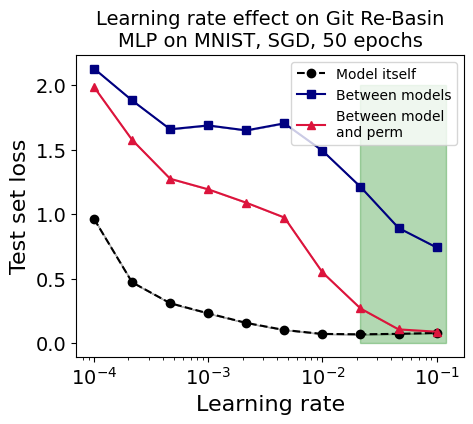

In [123]:
standard_bumps = np.array([d["bump_1_to_2"] for d in stored_results_dict])
permuted_bumps = np.array([d["bump_1_to_2perm"] for d in stored_results_dict])
model1_loss = np.array([d["model1_test_loss"] for d in stored_results_dict])
model2_loss = np.array([d["model2_test_loss"] for d in stored_results_dict])

standard_bumps = np.reshape(standard_bumps,[reps,-1])
permuted_bumps = np.reshape(permuted_bumps,[reps,-1])
model1_loss = np.reshape(model1_loss,[reps,-1])
model2_loss = np.reshape(model2_loss,[reps,-1])

def get_mean_and_error(vals):
  return np.mean(vals,axis=0), np.std(vals,axis=0)

mean_standard_bumps, error_standard_bumps = get_mean_and_error(standard_bumps)
mean_permuted_bumps, error_permuted_bumps = get_mean_and_error(permuted_bumps)
mean_model1_loss, error_model1_loss = get_mean_and_error(model1_loss)
mean_model2_loss, error_model2_loss = get_mean_and_error(model2_loss)

fig = plt.figure(figsize = (5,4),dpi=100)
fig.patch.set_facecolor('white')

plt.title(f"Learning rate effect on Git Re-Basin\nMLP on MNIST, SGD, {epochs} epochs",fontsize=14)

line, = plt.semilogx(LRs[:len(mean_standard_bumps)],(mean_model1_loss+mean_model2_loss)/2.0,marker="o",color="black",linestyle="--",label="Model itself")
plt.fill_between(LRs[:len(mean_standard_bumps)],
                 (mean_model1_loss+mean_model2_loss)/2.0-(error_model1_loss+error_model2_loss)/2.0,
                 (mean_model1_loss+mean_model2_loss)/2.0+(error_model1_loss+error_model2_loss)/2.0,
                 color=line.get_color(),
                 alpha=0.3
                 )

line, = plt.semilogx(LRs[:len(mean_standard_bumps)],mean_standard_bumps,marker="s",color="navy",label="Between models")
plt.fill_between(LRs[:len(mean_standard_bumps)],mean_standard_bumps-error_standard_bumps,mean_standard_bumps+error_standard_bumps,alpha=0.3,color=line.get_color())

line, = plt.semilogx(LRs[:len(mean_standard_bumps)],mean_permuted_bumps,marker="^",color="crimson",label="Between model\nand perm")
plt.fill_between(LRs[:len(mean_standard_bumps)],mean_permuted_bumps-error_permuted_bumps,mean_permuted_bumps+error_permuted_bumps,alpha=0.3,color=line.get_color())

from matplotlib.patches import Rectangle
currentAxis = plt.gca()
currentAxis.add_patch(Rectangle((LRs[-3], 0.0),0.1,2.0, fill=True, color="green", alpha=0.3))

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.xlabel("Learning rate",fontsize=16)
plt.ylabel("Test set loss",fontsize=16)

plt.legend(fontsize=10)
plt.show()

## Adam Experimental sweep

In [112]:
reps = 1
LRs = np.exp(np.linspace(np.log(0.5*1e-2),np.log(0.04),10))
optimizers = ["adam"]
epochs = 50

In [113]:
all_flattened_models_tuples = [] # collecting all solutions every
stored_results_dict = []

for rep in range(reps): # to get error bars
  for i_opt, optimizer in enumerate(optimizers):
    for i_LR, LR in enumerate(LRs):

      print("*****************************************")
      print(f"Experiment {len(stored_results_dict)} / {reps*len(optimizers)*len(LRs)}")

      flattened_models_list = get_optima(
          num_epochs = epochs,
          config_optimizer = optimizer,
          learning_rate = LR,
          seed = int(np.random.rand()*100000000),
          )
      
      flattened_model1 = flattened_models_list[0]
      flattened_model2 = flattened_models_list[1]
      results_dict = analyze_optima(flattened_model1,flattened_model2)

      results_dict["LR"] = LR
      results_dict["optimizer"] = optimizer
      results_dict["epochs"] = epochs
      
      stored_results_dict.append(results_dict)
      all_flattened_models_tuples.append(flattened_models_list)

      print(results_dict)

*****************************************
Experiment 0 / 10
--------------------------
Starting run 0
train_ds labels hash 1633421567493271265
test_ds labels hash -755657542732042722
num_train_examples 60000
num_test_examples 10000


100%|██████████| 50/50 [00:12<00:00,  3.92it/s]


-----------------
Run 0 DONE!
Run=0 test loss=0.19320808351039886 test accuracy=0.9793000221252441 train loss=0.014448828063905239 train accuracy=0.9976500272750854
--------------------------
Starting run 1
train_ds labels hash 1633421567493271265
test_ds labels hash -755657542732042722
num_train_examples 60000
num_test_examples 10000


100%|██████████| 50/50 [00:12<00:00,  3.94it/s]


-----------------
Run 1 DONE!
Run=1 test loss=0.16357706487178802 test accuracy=0.9788000583648682 train loss=0.013633685186505318 train accuracy=0.9970999956130981
0/P_0: 7807.2294921875
0/P_1: 2882.59130859375
0/P_2: 778.112548828125
1/P_0: 30.470703125
1/P_2: 0.0
1/P_1: 57.0576171875
2/P_2: 58.51220703125
2/P_0: 3.95703125
2/P_1: 14.72021484375
3/P_0: 1.83203125
3/P_1: 0.0029296875
3/P_2: 25.2197265625
4/P_0: 0.064453125
4/P_1: 4.38134765625
4/P_2: 7.2431640625
5/P_1: 2.513671875
5/P_2: 16.070068359375
5/P_0: 1.958984375
6/P_1: 1.6171875
6/P_2: 2.3212890625
6/P_0: 0.462890625
7/P_2: 0.0
7/P_1: 0.34765625
7/P_0: 0.5234375
8/P_1: 0.05810546875
8/P_0: 0.033203125
8/P_2: 2.71923828125
9/P_0: 0.0
9/P_1: 0.5966796875
9/P_2: 0.99169921875
10/P_2: 0.0
10/P_0: 0.1953125
10/P_1: 0.22900390625
11/P_0: 0.015625
11/P_2: 0.090087890625
11/P_1: 0.0
12/P_0: 0.0
12/P_1: 0.0
12/P_2: 0.0
{'model1_test_loss': DeviceArray(0.19320808, dtype=float32), 'model2_test_loss': DeviceArray(0.16357706, dtype=floa

100%|██████████| 50/50 [00:12<00:00,  3.96it/s]


-----------------
Run 0 DONE!
Run=0 test loss=0.17744825780391693 test accuracy=0.9806000590324402 train loss=0.007913080044090748 train accuracy=0.998033344745636
--------------------------
Starting run 1
train_ds labels hash 1633421567493271265
test_ds labels hash -755657542732042722
num_train_examples 60000
num_test_examples 10000


100%|██████████| 50/50 [00:12<00:00,  4.02it/s]


-----------------
Run 1 DONE!
Run=1 test loss=0.2338387817144394 test accuracy=0.978100061416626 train loss=0.013179200701415539 train accuracy=0.9973833560943604
0/P_0: 9584.2412109375
0/P_1: 3353.629150390625
0/P_2: 948.344482421875
1/P_0: 71.990234375
1/P_2: 0.0
1/P_1: 76.70654296875
2/P_2: 56.988525390625
2/P_0: 9.287109375
2/P_1: 18.310546875
3/P_0: 4.1953125
3/P_1: 0.2451171875
3/P_2: 35.262451171875
4/P_0: 0.7138671875
4/P_1: 5.5986328125
4/P_2: 5.65478515625
5/P_1: 2.986328125
5/P_2: 4.5
5/P_0: 2.751953125
6/P_1: 0.26123046875
6/P_2: 1.06591796875
6/P_0: 0.576171875
7/P_2: 0.0
7/P_1: 0.07275390625
7/P_0: 0.0517578125
8/P_1: 0.05224609375
8/P_0: 0.09765625
8/P_2: 0.12109375
9/P_0: 0.0
9/P_1: 0.03955078125
9/P_2: 1.669189453125
10/P_2: 0.0
10/P_0: 0.099609375
10/P_1: 0.04638671875
11/P_0: 0.15625
11/P_2: 0.08642578125
11/P_1: 0.01953125
12/P_0: 0.064453125
12/P_1: 0.0
12/P_2: 0.015625
13/P_2: 0.0
13/P_1: 0.0
13/P_0: 0.0
{'model1_test_loss': DeviceArray(0.17744826, dtype=float32),

100%|██████████| 50/50 [00:12<00:00,  3.97it/s]


-----------------
Run 0 DONE!
Run=0 test loss=0.19210897386074066 test accuracy=0.9798000454902649 train loss=0.015034694224596024 train accuracy=0.9970333576202393
--------------------------
Starting run 1
train_ds labels hash 1633421567493271265
test_ds labels hash -755657542732042722
num_train_examples 60000
num_test_examples 10000


100%|██████████| 50/50 [00:12<00:00,  3.94it/s]


-----------------
Run 1 DONE!
Run=1 test loss=0.1682424694299698 test accuracy=0.9798000454902649 train loss=0.015642572194337845 train accuracy=0.9967166781425476
0/P_0: 10331.5849609375
0/P_1: 4115.318359375
0/P_2: 1213.55859375
1/P_0: 45.83203125
1/P_2: 0.0
1/P_1: 69.5458984375
2/P_2: 61.57421875
2/P_0: 7.8603515625
2/P_1: 11.197265625
3/P_0: 4.40625
3/P_1: 0.0
3/P_2: 9.88037109375
4/P_0: 0.0
4/P_1: 4.58984375
4/P_2: 6.2626953125
5/P_1: 3.150390625
5/P_2: 7.451171875
5/P_0: 2.380859375
6/P_1: 4.28515625
6/P_2: 4.35693359375
6/P_0: 2.865234375
7/P_2: 0.0
7/P_1: 1.4150390625
7/P_0: 0.6640625
8/P_1: 0.0537109375
8/P_0: 0.640625
8/P_2: 0.77734375
9/P_0: 0.0
9/P_1: 0.6337890625
9/P_2: 1.24365234375
10/P_2: 0.0
10/P_0: 1.1376953125
10/P_1: 0.30859375
11/P_0: 0.3212890625
11/P_2: 0.1259765625
11/P_1: 0.07421875
12/P_0: 0.19140625
12/P_1: 0.0068359375
12/P_2: 0.64794921875
13/P_2: 0.0
13/P_1: 0.3720703125
13/P_0: 0.3203125
14/P_0: 0.0
14/P_2: 0.1142578125
14/P_1: 0.384765625
15/P_1: 0.0
15/

100%|██████████| 50/50 [00:12<00:00,  3.99it/s]


-----------------
Run 0 DONE!
Run=0 test loss=0.21782423555850983 test accuracy=0.9760000705718994 train loss=0.03651091083884239 train accuracy=0.9946500062942505
--------------------------
Starting run 1
train_ds labels hash 1633421567493271265
test_ds labels hash -755657542732042722
num_train_examples 60000
num_test_examples 10000


100%|██████████| 50/50 [00:12<00:00,  3.99it/s]


-----------------
Run 1 DONE!
Run=1 test loss=0.2368117719888687 test accuracy=0.9720000624656677 train loss=0.031393591314554214 train accuracy=0.9930166602134705
0/P_0: 11727.51171875
0/P_1: 4978.77490234375
0/P_2: 1348.96240234375
1/P_0: 70.095703125
1/P_2: 0.0
1/P_1: 112.45703125
2/P_2: 82.04638671875
2/P_0: 13.0078125
2/P_1: 23.7763671875
3/P_0: 6.84375
3/P_1: 0.2939453125
3/P_2: 21.171875
4/P_0: 0.7841796875
4/P_1: 9.845703125
4/P_2: 12.251953125
5/P_1: 4.703125
5/P_2: 7.50048828125
5/P_0: 4.732421875
6/P_1: 0.677734375
6/P_2: 0.0859375
6/P_0: 0.9921875
7/P_2: 0.0
7/P_1: 0.2744140625
7/P_0: 0.7841796875
8/P_1: 0.0
8/P_0: 0.0
8/P_2: 0.3603515625
9/P_0: 0.0
9/P_1: 0.2490234375
9/P_2: 0.30126953125
10/P_2: 0.0
10/P_0: 0.2958984375
10/P_1: 0.087890625
11/P_0: 0.3505859375
11/P_2: 0.994140625
11/P_1: 1.892578125
12/P_0: 1.4091796875
12/P_1: 0.162109375
12/P_2: 9.25439453125
13/P_2: 0.0
13/P_1: 2.2099609375
13/P_0: 1.369140625
14/P_0: 0.0
14/P_2: 1.05322265625
14/P_1: 0.515625
15/P_1: 

100%|██████████| 50/50 [00:12<00:00,  3.96it/s]


-----------------
Run 0 DONE!
Run=0 test loss=0.2616696059703827 test accuracy=0.9691000580787659 train loss=0.03131774440407753 train accuracy=0.9924166798591614
--------------------------
Starting run 1
train_ds labels hash 1633421567493271265
test_ds labels hash -755657542732042722
num_train_examples 60000
num_test_examples 10000


100%|██████████| 50/50 [00:12<00:00,  4.05it/s]


-----------------
Run 1 DONE!
Run=1 test loss=0.2120649814605713 test accuracy=0.9725000262260437 train loss=0.025349723175168037 train accuracy=0.9933500289916992
0/P_0: 9195.962890625
0/P_1: 6402.833984375
0/P_2: 1899.97802734375
1/P_0: 69.455078125
1/P_2: 0.0
1/P_1: 137.751953125
2/P_2: 37.7841796875
2/P_0: 18.431640625
2/P_1: 20.36328125
3/P_0: 8.36328125
3/P_1: 0.392578125
3/P_2: 27.724609375
4/P_0: 0.6298828125
4/P_1: 8.0419921875
4/P_2: 4.7265625
5/P_1: 3.46875
5/P_2: 2.7060546875
5/P_0: 5.080078125
6/P_1: 2.029296875
6/P_2: 0.58203125
6/P_0: 1.62890625
7/P_2: 0.0
7/P_1: 0.3232421875
7/P_0: 0.8486328125
8/P_1: 0.234375
8/P_0: 0.6083984375
8/P_2: 0.2109375
9/P_0: 0.0
9/P_1: 0.1669921875
9/P_2: 0.0419921875
10/P_2: 0.0
10/P_0: 0.13671875
10/P_1: 0.0
11/P_0: 0.0
11/P_2: 0.0
11/P_1: 0.0
{'model1_test_loss': DeviceArray(0.2616696, dtype=float32), 'model2_test_loss': DeviceArray(0.21206498, dtype=float32), 'model2_permuted_test_loss': DeviceArray(0.21206498, dtype=float32), 'bump_1_to

100%|██████████| 50/50 [00:12<00:00,  3.99it/s]


-----------------
Run 0 DONE!
Run=0 test loss=0.3076273500919342 test accuracy=0.9623000621795654 train loss=0.06496621668338776 train accuracy=0.9855000376701355
--------------------------
Starting run 1
train_ds labels hash 1633421567493271265
test_ds labels hash -755657542732042722
num_train_examples 60000
num_test_examples 10000


100%|██████████| 50/50 [00:12<00:00,  3.88it/s]


-----------------
Run 1 DONE!
Run=1 test loss=0.2717972993850708 test accuracy=0.9695000648498535 train loss=0.035081349313259125 train accuracy=0.9906333684921265
0/P_0: 13710.845703125
0/P_1: 7049.748046875
0/P_2: 2278.1201171875
1/P_0: 103.78515625
1/P_2: 0.0
1/P_1: 144.7587890625
2/P_2: 55.396484375
2/P_0: 24.943359375
2/P_1: 32.3427734375
3/P_0: 11.8828125
3/P_1: 1.03515625
3/P_2: 36.88671875
4/P_0: 1.130859375
4/P_1: 6.626953125
4/P_2: 6.1240234375
5/P_1: 3.8935546875
5/P_2: 2.478515625
5/P_0: 5.5078125
6/P_1: 1.943359375
6/P_2: 0.8896484375
6/P_0: 1.828125
7/P_2: 0.0
7/P_1: 0.4375
7/P_0: 0.681640625
8/P_1: 0.08984375
8/P_0: 0.41015625
8/P_2: 0.3740234375
9/P_0: 0.0
9/P_1: 0.4462890625
9/P_2: 0.2041015625
10/P_2: 0.0
10/P_0: 0.998046875
10/P_1: 0.5087890625
11/P_0: 0.3671875
11/P_2: 0.009765625
11/P_1: 0.052734375
12/P_0: 0.015625
12/P_1: 0.0205078125
12/P_2: -0.0009765625
13/P_2: 0.0
13/P_1: 0.0283203125
13/P_0: 0.076171875
14/P_0: 0.0
14/P_2: 0.1123046875
14/P_1: 0.5
15/P_1: 0.

100%|██████████| 50/50 [00:12<00:00,  3.94it/s]


-----------------
Run 0 DONE!
Run=0 test loss=0.2966727316379547 test accuracy=0.9572000503540039 train loss=0.07787275314331055 train accuracy=0.9795166850090027
--------------------------
Starting run 1
train_ds labels hash 1633421567493271265
test_ds labels hash -755657542732042722
num_train_examples 60000
num_test_examples 10000


100%|██████████| 50/50 [00:12<00:00,  3.98it/s]


-----------------
Run 1 DONE!
Run=1 test loss=0.2498445361852646 test accuracy=0.9529000520706177 train loss=0.0922274962067604 train accuracy=0.9736000299453735
0/P_0: 10116.064453125
0/P_1: 5990.2158203125
0/P_2: 2391.25390625
1/P_0: 154.4267578125
1/P_2: 0.0
1/P_1: 258.546875
2/P_2: 62.80859375
2/P_0: 43.4306640625
2/P_1: 25.3515625
3/P_0: 14.1728515625
3/P_1: 3.580078125
3/P_2: 16.6201171875
4/P_0: 2.888671875
4/P_1: 12.2578125
4/P_2: 5.8388671875
5/P_1: 4.0244140625
5/P_2: 8.625
5/P_0: 7.8466796875
6/P_1: 11.80078125
6/P_2: 6.978515625
6/P_0: 6.353515625
7/P_2: 0.0
7/P_1: 4.5234375
7/P_0: 2.54296875
8/P_1: 0.53515625
8/P_0: 0.3818359375
8/P_2: 3.8427734375
9/P_0: 0.0
9/P_1: 2.87890625
9/P_2: 1.4658203125
10/P_2: 0.0
10/P_0: 0.64453125
10/P_1: 1.0205078125
11/P_0: 1.2666015625
11/P_2: 0.36328125
11/P_1: 1.3466796875
12/P_0: 1.1904296875
12/P_1: 0.2666015625
12/P_2: 0.4736328125
13/P_2: 0.0
13/P_1: 0.3427734375
13/P_0: 0.322265625
14/P_0: 0.0
14/P_2: 0.15234375
14/P_1: 0.1044921875


100%|██████████| 50/50 [00:12<00:00,  4.00it/s]


-----------------
Run 0 DONE!
Run=0 test loss=0.24648551642894745 test accuracy=0.954300045967102 train loss=0.10184347629547119 train accuracy=0.9713166952133179
--------------------------
Starting run 1
train_ds labels hash 1633421567493271265
test_ds labels hash -755657542732042722
num_train_examples 60000
num_test_examples 10000


100%|██████████| 50/50 [00:12<00:00,  4.03it/s]


-----------------
Run 1 DONE!
Run=1 test loss=0.2649734616279602 test accuracy=0.9374000430107117 train loss=0.15673311054706573 train accuracy=0.9543166756629944
0/P_0: 11978.7919921875
0/P_1: 7051.6044921875
0/P_2: 3078.2177734375
1/P_0: 246.23046875
1/P_2: 0.0
1/P_1: 448.10546875
2/P_2: 96.4482421875
2/P_0: 73.51953125
2/P_1: 34.3125
3/P_0: 18.849609375
3/P_1: 5.2216796875
3/P_2: 15.3017578125
4/P_0: 4.455078125
4/P_1: 9.1220703125
4/P_2: 4.396484375
5/P_1: 3.703125
5/P_2: 0.791015625
5/P_0: 7.541015625
6/P_1: 3.8759765625
6/P_2: 0.5625
6/P_0: 4.75
7/P_2: 0.0
7/P_1: 1.9794921875
7/P_0: 0.240234375
8/P_1: 0.0478515625
8/P_0: 0.13671875
8/P_2: 0.171875
9/P_0: 0.0
9/P_1: 0.0498046875
9/P_2: 0.0625
10/P_2: 0.0
10/P_0: 0.044921875
10/P_1: 0.0
11/P_0: 0.0
11/P_2: 0.0
11/P_1: 0.0
{'model1_test_loss': DeviceArray(0.24648552, dtype=float32), 'model2_test_loss': DeviceArray(0.26497346, dtype=float32), 'model2_permuted_test_loss': DeviceArray(0.26497346, dtype=float32), 'bump_1_to_2': DeviceAr

100%|██████████| 50/50 [00:12<00:00,  4.02it/s]


-----------------
Run 0 DONE!
Run=0 test loss=0.27230602502822876 test accuracy=0.9319000244140625 train loss=0.19801366329193115 train accuracy=0.9446499943733215
--------------------------
Starting run 1
train_ds labels hash 1633421567493271265
test_ds labels hash -755657542732042722
num_train_examples 60000
num_test_examples 10000


100%|██████████| 50/50 [00:12<00:00,  4.01it/s]


-----------------
Run 1 DONE!
Run=1 test loss=0.28980347514152527 test accuracy=0.9304000735282898 train loss=0.20213346183300018 train accuracy=0.9447667002677917
0/P_0: 16563.05859375
0/P_1: 6196.4931640625
0/P_2: 3485.94384765625
1/P_0: 265.208984375
1/P_2: 0.0
1/P_1: 596.84375
2/P_2: 135.7314453125
2/P_0: 120.974609375
2/P_1: 100.9873046875
3/P_0: 36.091796875
3/P_1: 6.4521484375
3/P_2: 36.80859375
4/P_0: 6.61328125
4/P_1: 17.32421875
4/P_2: 9.8564453125
5/P_1: 7.0478515625
5/P_2: 3.376953125
5/P_0: 13.9609375
6/P_1: 6.880859375
6/P_2: 1.2900390625
6/P_0: 4.955078125
7/P_2: 0.0
7/P_1: 1.2021484375
7/P_0: 0.35546875
8/P_1: 0.0390625
8/P_0: 0.048828125
8/P_2: 0.73828125
9/P_0: 0.0
9/P_1: 0.6806640625
9/P_2: 2.3525390625
10/P_2: 0.0
10/P_0: 1.640625
10/P_1: 1.6181640625
11/P_0: 4.234375
11/P_2: 7.1064453125
11/P_1: 1.1484375
12/P_0: 1.146484375
12/P_1: 0.3564453125
12/P_2: 3.8994140625
13/P_2: 0.0
13/P_1: 0.5400390625
13/P_0: 7.98046875
14/P_0: 0.0
14/P_2: 0.2744140625
14/P_1: 1.05078

100%|██████████| 50/50 [00:12<00:00,  4.08it/s]


-----------------
Run 0 DONE!
Run=0 test loss=0.41462862491607666 test accuracy=0.8838000297546387 train loss=0.3603271245956421 train accuracy=0.8957666754722595
--------------------------
Starting run 1
train_ds labels hash 1633421567493271265
test_ds labels hash -755657542732042722
num_train_examples 60000
num_test_examples 10000


100%|██████████| 50/50 [00:12<00:00,  4.00it/s]


-----------------
Run 1 DONE!
Run=1 test loss=0.6302990317344666 test accuracy=0.8098000288009644 train loss=0.5874302983283997 train accuracy=0.8211333155632019
0/P_0: 18548.373046875
0/P_1: 5407.060546875
0/P_2: 3812.298828125
1/P_0: 480.609375
1/P_2: 0.0
1/P_1: 871.4111328125
2/P_2: 222.6318359375
2/P_0: 171.96875
2/P_1: 102.1171875
3/P_0: 62.93359375
3/P_1: 9.423828125
3/P_2: 72.51953125
4/P_0: 9.77734375
4/P_1: 38.85546875
4/P_2: 31.0673828125
5/P_1: 13.416015625
5/P_2: 27.955078125
5/P_0: 33.28125
6/P_1: 22.02734375
6/P_2: 11.78515625
6/P_0: 7.26953125
7/P_2: 0.0
7/P_1: 9.62890625
7/P_0: 6.2265625
8/P_1: 2.47265625
8/P_0: 0.73046875
8/P_2: 6.3955078125
9/P_0: 0.0
9/P_1: 1.224609375
9/P_2: 2.1630859375
10/P_2: 0.0
10/P_0: 1.4765625
10/P_1: 2.6171875
11/P_0: 0.43359375
11/P_2: 2.357421875
11/P_1: 2.240234375
12/P_0: 1.79296875
12/P_1: 1.8125
12/P_2: 7.8115234375
13/P_2: 0.0
13/P_1: 4.861328125
13/P_0: 6.453125
14/P_0: 0.0
14/P_2: 2.36328125
14/P_1: 2.45703125
15/P_1: 0.0
15/P_0: 2.

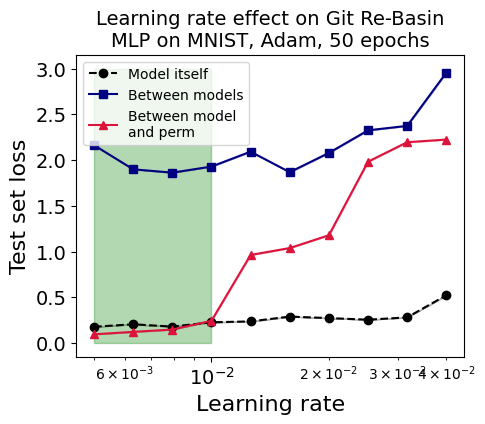

In [120]:
standard_bumps = np.array([d["bump_1_to_2"] for d in stored_results_dict])
permuted_bumps = np.array([d["bump_1_to_2perm"] for d in stored_results_dict])
model1_loss = np.array([d["model1_test_loss"] for d in stored_results_dict])
model2_loss = np.array([d["model2_test_loss"] for d in stored_results_dict])

standard_bumps = np.reshape(standard_bumps,[reps,-1])
permuted_bumps = np.reshape(permuted_bumps,[reps,-1])
model1_loss = np.reshape(model1_loss,[reps,-1])
model2_loss = np.reshape(model2_loss,[reps,-1])

def get_mean_and_error(vals):
  return np.mean(vals,axis=0), np.std(vals,axis=0)

mean_standard_bumps, error_standard_bumps = get_mean_and_error(standard_bumps)
mean_permuted_bumps, error_permuted_bumps = get_mean_and_error(permuted_bumps)
mean_model1_loss, error_model1_loss = get_mean_and_error(model1_loss)
mean_model2_loss, error_model2_loss = get_mean_and_error(model2_loss)

fig = plt.figure(figsize = (5,4),dpi=100)
fig.patch.set_facecolor('white')

plt.title(f"Learning rate effect on Git Re-Basin\nMLP on MNIST, Adam, {epochs} epochs",fontsize=14)

line, = plt.semilogx(LRs[:len(mean_standard_bumps)],(mean_model1_loss+mean_model2_loss)/2.0,marker="o",color="black",linestyle="--",label="Model itself")
plt.fill_between(LRs[:len(mean_standard_bumps)],
                 (mean_model1_loss+mean_model2_loss)/2.0-(error_model1_loss+error_model2_loss)/2.0,
                 (mean_model1_loss+mean_model2_loss)/2.0+(error_model1_loss+error_model2_loss)/2.0,
                 color=line.get_color(),
                 alpha=0.3
                 )

line, = plt.semilogx(LRs[:len(mean_standard_bumps)],mean_standard_bumps,marker="s",color="navy",label="Between models")
plt.fill_between(LRs[:len(mean_standard_bumps)],mean_standard_bumps-error_standard_bumps,mean_standard_bumps+error_standard_bumps,alpha=0.3,color=line.get_color())

line, = plt.semilogx(LRs[:len(mean_standard_bumps)],mean_permuted_bumps,marker="^",color="crimson",label="Between model\nand perm")
plt.fill_between(LRs[:len(mean_standard_bumps)],mean_permuted_bumps-error_permuted_bumps,mean_permuted_bumps+error_permuted_bumps,alpha=0.3,color=line.get_color())

from matplotlib.patches import Rectangle
currentAxis = plt.gca()
currentAxis.add_patch(Rectangle((LRs[0], 0.0),LRs[3]-LRs[0],3.0, fill=True, color="green", alpha=0.3))

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.xlabel("Learning rate",fontsize=16)
plt.ylabel("Test set loss",fontsize=16)

plt.legend(fontsize=10)
plt.show()